In [52]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
import collections
import os
from stats import *
from datetime import datetime
import numpy as np
import pandas as pd
import pickle as p
import random
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import DBSCAN,KMeans
#from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import scipy as sp
import pickle
from scipy.stats import itemfreq
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed,Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
import pandas as pd
import pickle as p
import random
import keras
from keras import backend as K
import tensorflow as tf
import nltk
import re
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
stop_words = set(stopwords.words('italian'))
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [53]:
data = pd.read_csv('data_set/2021-03-18_daily.csv',sep=';',dtype={'cod_mart':str,'cod_mdep':str,'codAgente':str,'codPtoVend':str})


In [54]:
data['anno'] = data['data_reg'].str[:4]

In [55]:
data['anno'] = data['anno'].astype('int')

In [56]:
data.rename(columns={'GGmese':'ggmese'},inplace=True)

In [57]:
data=data[(data.qta_venduta>=0) &(data.data_reg<'2021-03-10')]

In [58]:
df1 = data

In [59]:
df1.columns

Index(['cod_mart', 'cod_mdep', 'data_reg', 'mese', 'ggmese', 'settimana',
       'GGsettimana', 'ricorrenza', 'peso', 'descr_mgrp', 'descr_msgr',
       'descr_msfa', 'qta_cnf', 'gg_scad_partita', 'promoNoPromo', 'sum_promo',
       'QtaMediaVendGiorn', 'PrezzoMedioVendGiorn', 'day1_ptoVend',
       'day2_ptoVend', 'day3_ptoVend', 'day4_ptoVend', 'day5_ptoVend',
       'day6_ptoVend', 'day7_ptoVend', 'prezzo_vendita', 'min_prezzo_vendita',
       'max_prezzo_vendita', 'variazione_prezzo', 'min_variazione_prezzo',
       'stdev_variazione_prezzo', 'max_variazione_prezzo', 'dev_std_30',
       'media_30', 'media_15', 'media_7', 'QuantitaSostituita', 'QuantitaResa',
       'ConfRese', 'QuantitaOmaggi', 'inevaso', 'qta_venduta', 'anno'],
      dtype='object')

In [60]:
df1=df1[df1.descr_mgrp!='PARMALAT']
#df1=df1[~df1.cod_mart.isin(df1.cod_mart.value_counts()[500:].index)]

In [61]:
target=df1.groupby(['cod_mart','cod_mdep', 'descr_mgrp', 'descr_msgr', 'descr_msfa']).mean().drop(['anno','mese','ggmese','settimana','GGsettimana','sum_promo','ricorrenza','peso'],axis=1)
#target2=df1.groupby(['cod_mart','cod_mdep','codAgente', 'descr_mgrp', 'descr_msgr', 'descr_msfa','codCliente','codPtoVend']).max().drop(['mese','GGmese','settimana','GGsettimana', 'sum_promo','ricorrenza','peso'],axis=1)

In [62]:
target.fillna(0,inplace=True)

In [63]:
target.drop(['inevaso','QuantitaSostituita','QuantitaResa','QuantitaOmaggi','ConfRese'],axis=1,inplace=True)

In [64]:
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=20, max_iter=300)
kmeans.fit(target)
labels=kmeans.predict(target)
target['cluster']=labels

In [65]:
df1 = df1.merge(target['cluster'],on=['cod_mart','cod_mdep', 'descr_mgrp', 'descr_msgr', 'descr_msfa'],how='left')

In [66]:
target['cluster'].reset_index(level=0).to_csv('clusters_7_daily')

In [16]:
def creaVariabile_qtaVend_SETTprec(df):
    grouped_df2 = df.groupby(['cod_mart','cod_mdep','settimana'],as_index=False)['qta_venduta'].sum()    
    grouped_df2['qta_venduta_settPrec'] = grouped_df2\
                                .sort_values(['cod_mart','cod_mdep','settimana'])\
                                .qta_venduta.shift(1)
    df1 = pd.merge(df, grouped_df2[['cod_mart','cod_mdep','settimana','qta_venduta_settPrec']],
               how='left',
               on=['cod_mart','cod_mdep','settimana'])
    
    
    return df1

In [35]:
df1.columns

Index(['cod_mart', 'cod_mdep', 'data_reg', 'mese', 'ggmese', 'settimana',
       'GGsettimana', 'ricorrenza', 'peso', 'descr_mgrp', 'descr_msgr',
       'descr_msfa', 'qta_cnf', 'gg_scad_partita', 'promoNoPromo', 'sum_promo',
       'QtaMediaVendGiorn', 'PrezzoMedioVendGiorn', 'day1_ptoVend',
       'day2_ptoVend', 'day3_ptoVend', 'day4_ptoVend', 'day5_ptoVend',
       'day6_ptoVend', 'day7_ptoVend', 'prezzo_vendita', 'min_prezzo_vendita',
       'max_prezzo_vendita', 'variazione_prezzo', 'min_variazione_prezzo',
       'stdev_variazione_prezzo', 'max_variazione_prezzo', 'dev_std_30',
       'media_30', 'media_15', 'media_7', 'QuantitaSostituita', 'QuantitaResa',
       'ConfRese', 'QuantitaOmaggi', 'inevaso', 'qta_venduta', 'anno',
       'cluster', 'qta_venduta_prec_sett_sum', 'qta_venduta_prec_sett_mean',
       'qta_venduta_prec_sett_max', 'qta_venduta_prec_dep_sum',
       'qta_venduta_prec_dep_mean', 'qta_venduta_prec_dep_max',
       'qta_venduta_prec_mgrp_sum', 'qta_venduta_pre

In [67]:
df1=shifted_standard_feature(df1,'qta_venduta_prec_sett_sum',['cod_mart','anno','settimana'],'qta_venduta','sum',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_sett_mean',['cod_mart','anno','settimana'],'qta_venduta','mean',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_sett_max',['cod_mart','anno','settimana'],'qta_venduta','max',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_dep_sum',['cod_mart','data_reg'],'qta_venduta','sum',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_dep_mean',['cod_mart','data_reg'],'qta_venduta','mean',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_dep_max',['cod_mart','data_reg'],'qta_venduta','max',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_mgrp_sum',['cod_mdep','descr_mgrp','data_reg'],'qta_venduta','sum',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msgr_sum',['cod_mdep','descr_msgr','data_reg'],'qta_venduta','sum',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msfa_sum',['cod_mdep','descr_msfa','data_reg'],'qta_venduta','sum',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_mgrp_mean',['cod_mdep','descr_mgrp','data_reg'],'qta_venduta','mean',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msgr_mean',['cod_mdep','descr_msgr','data_reg'],'qta_venduta','mean',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msfa_mean',['cod_mdep','descr_msfa','data_reg'],'qta_venduta','mean',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_mgrp_max',['cod_mdep','descr_mgrp','data_reg'],'qta_venduta','max',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msgr_max',['cod_mdep','descr_msgr','data_reg'],'qta_venduta','max',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msfa_max',['cod_mdep','descr_msfa','data_reg'],'qta_venduta','max',1)

In [68]:
df1=rolling_feature(df1,'qta_venduta_prec_anno_mean',['cod_mdep','cod_mart','settimana','GGsettimana','anno'],\
                    ['cod_mdep','cod_mart','settimana','GGsettimana'],'qta_venduta','mean',3,1)

In [69]:
def convert_time(end_date):
    
    # Remove on period and after
    end_date = end_date.split(" ")
    end_date[-1] = end_date[-1][:12]
    end_date = " ".join(end_date)

    return end_date

In [70]:
df_meteo=pd.read_csv('meteo_bari',index_col=0)

In [71]:
df_meteo['data_reg']=df_meteo['data_reg'].apply(convert_time)
df_l=df1[~(df1.data_reg.isin(df_meteo.data_reg.unique()))]

In [72]:
import time as tm
from forecastiopy import *
apikey = '679f07cc6e387621a41b11bf17989d90'
citta='BARI'
dep_cit = np.load('dep_cit.npy',allow_pickle=True).item()
date_list=df_l['data_reg'].unique()
for i in date_list:
    
        i= datetime.strptime(i, '%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%dT%H:%M:%S')
        print(i)
        dep_cit[citta]['date'][i]={"meteo":dict()}
        tm.sleep(1)
        fio = ForecastIO.ForecastIO(apikey,
                                        units=ForecastIO.ForecastIO.UNITS_SI,
                                        lang=ForecastIO.ForecastIO.LANG_ITALIAN,
                                        latitude=dep_cit[citta]['coordinate'][0], 
                                        longitude=dep_cit[citta]['coordinate'][1],
                                        time=i
                                   )
        dep_cit[citta]['date'][i]['meteo']=fio.daily['data'][0]
        df_comp=pd.DataFrame.from_dict(dep_cit[citta]['date'][str(i)],orient="index")
        df_comp['data_reg']=datetime.strptime(i,'%Y-%m-%dT%H:%M:%S').strftime('%Y-%m-%d %H:%M:%S.%f')
        df_comp['citta']=citta
        df_meteo=df_meteo.append(df_comp)
        df_meteo=df_meteo.drop_duplicates()
        df_meteo=df_meteo.reset_index(drop=True)
        
        df_meteo.to_csv('meteo_bari')   
       


In [73]:
df_meteoN = df_meteo.copy()
df_meteoN = df_meteoN[df_meteoN.citta=='BARI']
df_meteoN['index'] = df_meteoN.index
df_meteoN = df_meteoN.loc[df_meteoN.groupby("data_reg")["index"].idxmax()]
df1 = pd.merge(df1, df_meteoN[df_meteoN.citta=='BARI'][['data_reg','apparentTemperatureMax','apparentTemperatureMin','cloudCover','humidity','precipIntensity','precipIntensityMax','precipProbability','windBearing','windSpeed','icon']],
               how='left',
               on=['data_reg'])

In [74]:
df1['apparentTemperatureMax'].fillna(0,inplace=True)
df1['apparentTemperatureMin'].fillna(0,inplace=True)
df1['cloudCover'].fillna(0,inplace=True)
df1['humidity'].fillna(0,inplace=True)
df1['precipIntensity'].fillna(0,inplace=True)
df1['precipIntensityMax'].fillna(0,inplace=True)
df1['precipProbability'].fillna(0,inplace=True)
df1['windBearing'].fillna(0,inplace=True)
df1['windSpeed'].fillna(0,inplace=True)

In [75]:
#introduzione stop_words
stop_words.add('lt')
stop_words.add('pz')
stop_words.add('pezzi')
stop_words.add('pezz')
stop_words.add('fresco')
stop_words.add('freschi')
stop_words.add('chef')
stop_words.add('int')
stop_words.add('gr')
stop_words.add('kg')
stop_words.add('cucina')
stop_words.add('flash')
stop_words.add('intero')
stop_words.add('scremato')
stop_words.add('parz')
stop_words.add('ca')
stop_words.add('uh')
stop_words.add('uht')
stop_words.add('%')
stop_words.add('g')
stop_words.add('fr')
stop_words.add('fresca')
stop_words.add('fresche')
stop_words.add('mix')
stop_words.add('bio')
stop_words.add('gran')
stop_words.add('picc')
stop_words.add('sv')
stop_words.add('grande')
stop_words.add('piccolo')
stop_words.add('rosso')
stop_words.add('nero')
stop_words.add('giallo')
stop_words.add('verde')
stop_words.add('arancione')
stop_words.add('blu')
stop_words.add('più')
stop_words.add('piu')
stop_words.add('pf')
stop_words.add('l')
stop_words.add('ml')
stop_words.add('mg')

#ripulisco gruppo sottogruppo e sottofamiglia
a= df1[['cod_mart','descr_mgrp','descr_msgr','descr_msfa']].drop_duplicates()
a.descr_mgrp.fillna('',inplace=True)
a.descr_msgr.fillna('',inplace=True)
a.descr_msfa.fillna('',inplace=True)
new_df=pd.DataFrame(data=a)

for i in range(len(a)):
    row=a.iloc[i]
    word_tokenize= RegexpTokenizer(r'\w+')
    mgrp = word_tokenize.tokenize(row[1])
    msgr = word_tokenize.tokenize(row[2])
    msfa = word_tokenize.tokenize(row[3])
    msgr1  = [word for word in msgr if word not in mgrp and not re.search("\d", word) and not word.lower()  in stop_words]
    msfa1 = [word for word in msfa if word not in mgrp  and not re.search("\d", word) and not word.lower()  in stop_words]
    msfa2 = [word for word in msfa1 if word not in msgr and not re.search("\d", word) and not word.lower()  in stop_words]
    if len(msgr1)==0:
        msgr1=msgr
    if len(msfa1)==0:
        msfa1=msfa
    if len(msfa2)==0:
        msfa2=msfa1
    new_df.loc[new_df['cod_mart']==row.cod_mart,'descr_msgr']= ' '.join(msgr1)
    new_df.loc[new_df['cod_mart']==row.cod_mart,'descr_msfa']= ' '.join(msfa2)
    

#Applico TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
corpus =new_df.descr_msfa
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

#print(vectorizer.get_feature_names())

def min_sparse(X):
    if len(X.data) == 0:
        return 0
    m = X.data.min()
    return m if X.getnnz() == X.size else min(m, 0)

from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

'''ps = SnowballStemmer('italian')
descr_msfa=[]
for i in range(len(corpus)):
    trovato=False
    for j in X[i].indices:
        if X[i,j]==min_sparse(X[i]):
            descr_msfa.append(ps.stem(vectorizer.get_feature_names()[j]))
            trovato=True
            break
    if trovato==False:
        descr_msfa.append(new_df.iloc[i].descr_msgr)
new_df['descr_msfa']=descr_msfa
'''
df1.rename(columns={'descr_mgrp':'d1','descr_msgr':'d2','descr_msfa':'d3'}, inplace=True)
df1=df1.merge(new_df, how='left', on ='cod_mart')

In [76]:
import gensim
from sklearn.decomposition import PCA
model=  gensim.models.KeyedVectors.load_word2vec_format("model.bin",binary=True)
def avg_sentence(sentences, wv):
    first=True
    for sentence in sentences:
        v = np.zeros(100)
        for w in sentence.split():
            if w.lower() in wv:
                v += wv[w.lower()]
        if first:
            df=pd.DataFrame((v / len(sentence.split()))).T
            first=False
        else: 
            df1=pd.DataFrame((v / len(sentence.split()))).T
            df=df.append(df1)
    return df
df2=df1[['cod_mart','descr_mgrp','descr_msgr','descr_msfa']].drop_duplicates()
df =avg_sentence(df2['descr_mgrp'].astype(str) + " "+ df2['descr_msgr'].astype(str)+" " + df2['descr_msfa'].astype(str),model).reset_index(drop=True)

pca = PCA(10)
pca.fit(df.fillna(0.0))
df=pd.DataFrame(pca.transform(df.fillna(0)))
df2=pd.concat([df,df2['cod_mart'].reset_index(drop=True)],axis=1)
df1=df1.merge(df2, how='left', on ='cod_mart')

<ipython-input-76-1876ce837cc4>:15: RuntimeWarning: invalid value encountered in true_divide
  df1=pd.DataFrame((v / len(sentence.split()))).T


In [77]:
cardinality=df1['cod_mart'].unique()
sales_mapping_art = dict(zip(cardinality, range(0, len(cardinality))))
df1['cod_mart'] = df1['cod_mart'].map(sales_mapping_art).astype(int)

cardinality=df1['cod_mdep'].unique()
sales_mapping_dep = dict(zip(cardinality, range(0, len(cardinality))))
df1['cod_mdep'] = df1['cod_mdep'].map(sales_mapping_dep).astype(int)

df1['peso'].fillna(1.0,inplace=True)

cardinality=df1['descr_mgrp'].unique()
sales_mapping_descr_mgrp = dict(zip(cardinality, range(0, len(cardinality))))


cardinality=df1['descr_msgr'].unique()
sales_mapping_descr_msgr = dict(zip(cardinality, range(0, len(cardinality))))

cardinality=df1['descr_msfa'].unique()
sales_mapping_descr_msfa = dict(zip(cardinality, range(0, len(cardinality))))


unique_dict={}
elements=df1[['d1','d2','d3','descr_mgrp','descr_msgr','descr_msfa',\
0,1,2,3,4,5,6,7,8,9]].drop_duplicates()
for element in range(len(elements)):
    row=elements.iloc[element]
    val=str(elements['d1'].values[element])+" "+str(elements['d2'].values[element])+" "+str(elements['d3'].values[element])
    if val not in unique_dict:
        unique_dict[val]={'descr_mgrp':'','descr_msgr':'','descr_msfa':'','0':0 ,'1':0 ,'2':0 ,'3':0 ,'4':0 ,'5':0 ,'6':0 ,'7':0 ,'8':0 ,'9':0 ,}
        unique_dict[val]['descr_mgrp']=sales_mapping_descr_mgrp[row.descr_mgrp]
        unique_dict[val]['descr_msgr']=sales_mapping_descr_msgr[row.descr_msgr]
        unique_dict[val]['descr_msfa']=sales_mapping_descr_msfa[row.descr_msfa]
        unique_dict[val]['0']=row[0]
        unique_dict[val]['1']=row[1]
        unique_dict[val]['2']=row[2]
        unique_dict[val]['3']=row[3]
        unique_dict[val]['4']=row[4]
        unique_dict[val]['5']=row[5]
        unique_dict[val]['6']=row[6]
        unique_dict[val]['7']=row[7]
        unique_dict[val]['8']=row[8]
        unique_dict[val]['9']=row[9]

        
df1.drop(['d1','d2','d3'],axis=1, inplace=True)
df1['descr_mgrp'] = df1['descr_mgrp'].map(sales_mapping_descr_mgrp).astype(int)
df1['descr_msgr'] = df1['descr_msgr'].map(sales_mapping_descr_msgr).astype(int)
df1['descr_msfa'] = df1['descr_msfa'].map(sales_mapping_descr_msfa).astype(int)

In [78]:
np.save('dictionaries/dep.npy', sales_mapping_dep)
np.save('dictionaries/unique_dict.npy', unique_dict)

In [79]:
df1['anno'] = df1['anno'].astype('int')

In [80]:
df_train = df1.loc[(df1['anno']>2017)] 
df_val = df1.loc[df1['anno'] ==2021] 
df_test=df1.loc[df1['anno'] ==2020]

In [81]:
df_val.anno.unique()

array([2021])

In [82]:
df_val.drop('anno',axis=1, inplace=True)
df_train.drop('anno',axis=1 , inplace=True)
df_test.drop('anno',axis=1 , inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [83]:
df_train=df_train[df_train.qta_venduta>=0]
df_val=df_val[df_val.qta_venduta>=0]

In [84]:
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [85]:
X, y =df_train.drop(['cod_mart','qta_venduta','data_reg'],axis=1),df_train['qta_venduta']
#X_train, X_test,X_val, y_train, y_test,y_val=X,df_test.drop(['qta_venduta'],axis=1),df_val.drop(['cod_mart','qta_venduta'],
 #                                                                                                axis=1),y,df_test['qta_venduta'],df_val['qta_venduta']
X_train,X_val,X_test, y_train,y_val,y_test=X,df_val.drop(['cod_mart','qta_venduta','data_reg'],axis=1),\
                                            df_test.drop(['cod_mart','qta_venduta','data_reg'],axis=1),\
                                            y,df_val['qta_venduta'],df_test['qta_venduta']


In [86]:
X_val.drop(['QuantitaSostituita',
       'inevaso', 'QuantitaResa', 'ConfRese', 'QuantitaOmaggi'],axis=1,inplace=True)
X_train.drop(['QuantitaSostituita',
       'inevaso', 'QuantitaResa', 'ConfRese', 'QuantitaOmaggi'],axis=1,inplace=True)
X_test.drop(['QuantitaSostituita',
       'inevaso', 'QuantitaResa', 'ConfRese', 'QuantitaOmaggi'],axis=1,inplace=True)
X_test['cluster'].fillna(25,inplace=True)
X_train['cluster'].fillna(25,inplace=True)
X_val['cluster'].fillna(25,inplace=True)

In [87]:
X_train.drop('icon', axis=1, inplace=True)
X_val.drop('icon', axis=1, inplace=True)

In [88]:
X_train.fillna(0,inplace=True)
X_val.fillna(0,inplace=True)

In [120]:
X_train.columns

Index([                  'cod_mdep',                       'mese',
                           'ggmese',                  'settimana',
                      'GGsettimana',                 'ricorrenza',
                             'peso',                    'qta_cnf',
                  'gg_scad_partita',               'promoNoPromo',
                        'sum_promo',          'QtaMediaVendGiorn',
             'PrezzoMedioVendGiorn',               'day1_ptoVend',
                     'day2_ptoVend',               'day3_ptoVend',
                     'day4_ptoVend',               'day5_ptoVend',
                     'day6_ptoVend',               'day7_ptoVend',
                   'prezzo_vendita',         'min_prezzo_vendita',
               'max_prezzo_vendita',          'variazione_prezzo',
            'min_variazione_prezzo',    'stdev_variazione_prezzo',
            'max_variazione_prezzo',                 'dev_std_30',
                         'media_30',                   'media_

In [117]:
from catboost import CatBoostRegressor
X_train.cluster=X_train.cluster.astype('int32')
X_val.cluster=X_val.cluster.astype('int32')
X_train.promoNoPromo=X_train.promoNoPromo.astype('int32')
X_train.gg_scad_partita=X_train.gg_scad_partita.astype('int32')
X_val.gg_scad_partita=X_val.gg_scad_partita.astype('int32')
X_val.promoNoPromo=X_val.promoNoPromo.astype('int32')
model = CatBoostRegressor(
n_estimators = 8000,#7345#2755
loss_function = 'MAE',
eval_metric = 'MAE',
depth=12,
cat_features =[0,1,2,3,4,5,8,9,10,31,59,58,57] )#1.7582339

In [114]:
grid = {
        'depth': [12]}

In [118]:
model.fit(X_train,y_train)

0:	learn: 64.3715819	total: 1.39s	remaining: 3h 5m 10s
1:	learn: 63.1770507	total: 2.85s	remaining: 3h 9m 59s
2:	learn: 62.1743567	total: 4.32s	remaining: 3h 11m 57s
3:	learn: 61.1563297	total: 5.68s	remaining: 3h 9m 16s
4:	learn: 60.2348943	total: 7.15s	remaining: 3h 10m 32s
5:	learn: 59.4281577	total: 8.6s	remaining: 3h 10m 53s
6:	learn: 58.3838917	total: 9.99s	remaining: 3h 10m 4s
7:	learn: 57.5315452	total: 11.3s	remaining: 3h 8m 46s
8:	learn: 56.5397786	total: 12.7s	remaining: 3h 8m 33s
9:	learn: 55.7324306	total: 14.1s	remaining: 3h 8m 8s
10:	learn: 55.0154952	total: 15.6s	remaining: 3h 8m 33s
11:	learn: 54.2524996	total: 17s	remaining: 3h 9m 2s
12:	learn: 53.3787121	total: 18.4s	remaining: 3h 7m 54s
13:	learn: 52.5279503	total: 19.7s	remaining: 3h 7m 3s
14:	learn: 51.6565920	total: 21s	remaining: 3h 6m 7s
15:	learn: 50.9125310	total: 22.3s	remaining: 3h 5m 43s
16:	learn: 50.2499973	total: 23.8s	remaining: 3h 5m 57s
17:	learn: 49.6203703	total: 25.1s	remaining: 3h 5m 15s
18:	lear

145:	learn: 23.4253658	total: 3m 24s	remaining: 3h 3m 19s
146:	learn: 23.4244696	total: 3m 25s	remaining: 3h 3m 20s
147:	learn: 23.3900410	total: 3m 27s	remaining: 3h 3m 14s
148:	learn: 23.3818207	total: 3m 28s	remaining: 3h 3m 13s
149:	learn: 23.3789161	total: 3m 30s	remaining: 3h 3m 15s
150:	learn: 23.3722806	total: 3m 31s	remaining: 3h 3m 14s
151:	learn: 23.3633991	total: 3m 32s	remaining: 3h 3m 15s
152:	learn: 23.3134364	total: 3m 34s	remaining: 3h 3m 16s
153:	learn: 23.2779298	total: 3m 35s	remaining: 3h 3m 16s
154:	learn: 23.2772981	total: 3m 37s	remaining: 3h 3m 16s
155:	learn: 23.2766346	total: 3m 38s	remaining: 3h 3m 20s
156:	learn: 23.2469563	total: 3m 40s	remaining: 3h 3m 18s
157:	learn: 23.2215910	total: 3m 41s	remaining: 3h 3m 20s
158:	learn: 23.2208879	total: 3m 43s	remaining: 3h 3m 26s
159:	learn: 23.2021613	total: 3m 44s	remaining: 3h 3m 27s
160:	learn: 23.1651805	total: 3m 46s	remaining: 3h 3m 29s
161:	learn: 23.1202097	total: 3m 47s	remaining: 3h 3m 26s
162:	learn: 23

288:	learn: 21.2165963	total: 6m 53s	remaining: 3h 4m 4s
289:	learn: 21.2002009	total: 6m 55s	remaining: 3h 4m 6s
290:	learn: 21.1883168	total: 6m 56s	remaining: 3h 4m 2s
291:	learn: 21.1495192	total: 6m 58s	remaining: 3h 4m
292:	learn: 21.1289154	total: 6m 59s	remaining: 3h 4m 6s
293:	learn: 21.1060423	total: 7m 1s	remaining: 3h 4m 4s
294:	learn: 21.0698416	total: 7m 2s	remaining: 3h 4m 5s
295:	learn: 21.0422798	total: 7m 4s	remaining: 3h 4m 6s
296:	learn: 21.0149704	total: 7m 5s	remaining: 3h 4m 6s
297:	learn: 20.9843564	total: 7m 7s	remaining: 3h 4m 6s
298:	learn: 20.9403692	total: 7m 8s	remaining: 3h 4m 6s
299:	learn: 20.9273849	total: 7m 10s	remaining: 3h 4m 4s
300:	learn: 20.9078140	total: 7m 11s	remaining: 3h 4m 2s
301:	learn: 20.8945198	total: 7m 13s	remaining: 3h 4m 4s
302:	learn: 20.8934009	total: 7m 14s	remaining: 3h 4m 1s
303:	learn: 20.8732261	total: 7m 15s	remaining: 3h 3m 57s
304:	learn: 20.8541742	total: 7m 17s	remaining: 3h 3m 57s
305:	learn: 20.8407241	total: 7m 18s	r

431:	learn: 19.6165777	total: 10m 34s	remaining: 3h 5m 9s
432:	learn: 19.6160924	total: 10m 35s	remaining: 3h 5m 9s
433:	learn: 19.6026576	total: 10m 37s	remaining: 3h 5m 8s
434:	learn: 19.5872962	total: 10m 39s	remaining: 3h 5m 14s
435:	learn: 19.5728789	total: 10m 40s	remaining: 3h 5m 17s
436:	learn: 19.5661231	total: 10m 42s	remaining: 3h 5m 18s
437:	learn: 19.5573135	total: 10m 43s	remaining: 3h 5m 16s
438:	learn: 19.5248570	total: 10m 45s	remaining: 3h 5m 13s
439:	learn: 19.5243638	total: 10m 46s	remaining: 3h 5m 11s
440:	learn: 19.5060213	total: 10m 48s	remaining: 3h 5m 10s
441:	learn: 19.4950896	total: 10m 49s	remaining: 3h 5m 10s
442:	learn: 19.4947747	total: 10m 51s	remaining: 3h 5m 7s
443:	learn: 19.4841966	total: 10m 52s	remaining: 3h 5m 5s
444:	learn: 19.4838385	total: 10m 53s	remaining: 3h 5m 1s
445:	learn: 19.4836761	total: 10m 55s	remaining: 3h 4m 58s
446:	learn: 19.4834258	total: 10m 56s	remaining: 3h 4m 55s
447:	learn: 19.4832639	total: 10m 58s	remaining: 3h 4m 53s
448

572:	learn: 18.6398789	total: 14m 7s	remaining: 3h 3m 4s
573:	learn: 18.6269774	total: 14m 8s	remaining: 3h 3m 2s
574:	learn: 18.6264612	total: 14m 10s	remaining: 3h 3m
575:	learn: 18.6259509	total: 14m 11s	remaining: 3h 2m 58s
576:	learn: 18.6238946	total: 14m 13s	remaining: 3h 2m 57s
577:	learn: 18.6069513	total: 14m 14s	remaining: 3h 2m 55s
578:	learn: 18.6053816	total: 14m 16s	remaining: 3h 2m 52s
579:	learn: 18.5993701	total: 14m 17s	remaining: 3h 2m 52s
580:	learn: 18.5910668	total: 14m 19s	remaining: 3h 2m 49s
581:	learn: 18.5909446	total: 14m 20s	remaining: 3h 2m 46s
582:	learn: 18.5794702	total: 14m 21s	remaining: 3h 2m 44s
583:	learn: 18.5711071	total: 14m 23s	remaining: 3h 2m 43s
584:	learn: 18.5583310	total: 14m 24s	remaining: 3h 2m 40s
585:	learn: 18.5556914	total: 14m 26s	remaining: 3h 2m 38s
586:	learn: 18.5447177	total: 14m 27s	remaining: 3h 2m 36s
587:	learn: 18.5315634	total: 14m 29s	remaining: 3h 2m 37s
588:	learn: 18.5313387	total: 14m 30s	remaining: 3h 2m 35s
589:	

714:	learn: 17.6992244	total: 17m 39s	remaining: 2h 59m 59s
715:	learn: 17.6940010	total: 17m 41s	remaining: 2h 59m 57s
716:	learn: 17.6894866	total: 17m 42s	remaining: 2h 59m 54s
717:	learn: 17.6887115	total: 17m 44s	remaining: 2h 59m 53s
718:	learn: 17.6879568	total: 17m 45s	remaining: 2h 59m 53s
719:	learn: 17.6794197	total: 17m 47s	remaining: 2h 59m 52s
720:	learn: 17.6773651	total: 17m 48s	remaining: 2h 59m 51s
721:	learn: 17.6615079	total: 17m 50s	remaining: 2h 59m 49s
722:	learn: 17.6550228	total: 17m 51s	remaining: 2h 59m 48s
723:	learn: 17.6410289	total: 17m 53s	remaining: 2h 59m 45s
724:	learn: 17.6407986	total: 17m 54s	remaining: 2h 59m 44s
725:	learn: 17.6252311	total: 17m 56s	remaining: 2h 59m 42s
726:	learn: 17.6250683	total: 17m 57s	remaining: 2h 59m 40s
727:	learn: 17.6064273	total: 17m 59s	remaining: 2h 59m 40s
728:	learn: 17.5934666	total: 18m	remaining: 2h 59m 38s
729:	learn: 17.5579059	total: 18m 2s	remaining: 2h 59m 35s
730:	learn: 17.5533597	total: 18m 3s	remainin

852:	learn: 16.8025793	total: 21m 9s	remaining: 2h 57m 18s
853:	learn: 16.7812704	total: 21m 11s	remaining: 2h 57m 16s
854:	learn: 16.7805314	total: 21m 12s	remaining: 2h 57m 15s
855:	learn: 16.7764502	total: 21m 14s	remaining: 2h 57m 14s
856:	learn: 16.7612968	total: 21m 15s	remaining: 2h 57m 13s
857:	learn: 16.7405051	total: 21m 17s	remaining: 2h 57m 11s
858:	learn: 16.7319426	total: 21m 18s	remaining: 2h 57m 9s
859:	learn: 16.7314169	total: 21m 20s	remaining: 2h 57m 7s
860:	learn: 16.7151203	total: 21m 21s	remaining: 2h 57m 5s
861:	learn: 16.7055249	total: 21m 22s	remaining: 2h 57m 2s
862:	learn: 16.6922705	total: 21m 24s	remaining: 2h 57m
863:	learn: 16.6914771	total: 21m 25s	remaining: 2h 56m 58s
864:	learn: 16.6810475	total: 21m 27s	remaining: 2h 56m 56s
865:	learn: 16.6808589	total: 21m 28s	remaining: 2h 56m 53s
866:	learn: 16.6744858	total: 21m 30s	remaining: 2h 56m 53s
867:	learn: 16.6657436	total: 21m 31s	remaining: 2h 56m 51s
868:	learn: 16.6559601	total: 21m 32s	remaining: 

990:	learn: 16.0051546	total: 24m 39s	remaining: 2h 54m 27s
991:	learn: 16.0005554	total: 24m 41s	remaining: 2h 54m 26s
992:	learn: 15.9981886	total: 24m 43s	remaining: 2h 54m 25s
993:	learn: 15.9973493	total: 24m 44s	remaining: 2h 54m 23s
994:	learn: 15.9963606	total: 24m 45s	remaining: 2h 54m 21s
995:	learn: 15.9962039	total: 24m 47s	remaining: 2h 54m 19s
996:	learn: 15.9935921	total: 24m 49s	remaining: 2h 54m 19s
997:	learn: 15.9929355	total: 24m 50s	remaining: 2h 54m 19s
998:	learn: 15.9872266	total: 24m 52s	remaining: 2h 54m 19s
999:	learn: 15.9871122	total: 24m 54s	remaining: 2h 54m 22s
1000:	learn: 15.9870103	total: 24m 56s	remaining: 2h 54m 22s
1001:	learn: 15.9855493	total: 24m 57s	remaining: 2h 54m 21s
1002:	learn: 15.9833721	total: 24m 59s	remaining: 2h 54m 20s
1003:	learn: 15.9755018	total: 25m	remaining: 2h 54m 18s
1004:	learn: 15.9723641	total: 25m 2s	remaining: 2h 54m 16s
1005:	learn: 15.9722183	total: 25m 3s	remaining: 2h 54m 14s
1006:	learn: 15.9716116	total: 25m 5s	re

1126:	learn: 15.5820861	total: 28m 16s	remaining: 2h 52m 25s
1127:	learn: 15.5795966	total: 28m 18s	remaining: 2h 52m 25s
1128:	learn: 15.5794146	total: 28m 19s	remaining: 2h 52m 23s
1129:	learn: 15.5793231	total: 28m 21s	remaining: 2h 52m 22s
1130:	learn: 15.5789863	total: 28m 22s	remaining: 2h 52m 21s
1131:	learn: 15.5768166	total: 28m 24s	remaining: 2h 52m 19s
1132:	learn: 15.5757315	total: 28m 26s	remaining: 2h 52m 19s
1133:	learn: 15.5755587	total: 28m 27s	remaining: 2h 52m 19s
1134:	learn: 15.5745418	total: 28m 29s	remaining: 2h 52m 17s
1135:	learn: 15.5705570	total: 28m 30s	remaining: 2h 52m 16s
1136:	learn: 15.5696916	total: 28m 32s	remaining: 2h 52m 15s
1137:	learn: 15.5695239	total: 28m 33s	remaining: 2h 52m 13s
1138:	learn: 15.5694228	total: 28m 35s	remaining: 2h 52m 13s
1139:	learn: 15.5672857	total: 28m 37s	remaining: 2h 52m 12s
1140:	learn: 15.5646182	total: 28m 38s	remaining: 2h 52m 10s
1141:	learn: 15.5645087	total: 28m 40s	remaining: 2h 52m 10s
1142:	learn: 15.5638191	

1262:	learn: 15.1676133	total: 31m 54s	remaining: 2h 50m 11s
1263:	learn: 15.1665506	total: 31m 56s	remaining: 2h 50m 11s
1264:	learn: 15.1633760	total: 31m 57s	remaining: 2h 50m 10s
1265:	learn: 15.1597019	total: 31m 59s	remaining: 2h 50m 9s
1266:	learn: 15.1593634	total: 32m	remaining: 2h 50m 8s
1267:	learn: 15.1521885	total: 32m 2s	remaining: 2h 50m 6s
1268:	learn: 15.1519993	total: 32m 4s	remaining: 2h 50m 6s
1269:	learn: 15.1517192	total: 32m 5s	remaining: 2h 50m 5s
1270:	learn: 15.1495959	total: 32m 7s	remaining: 2h 50m 4s
1271:	learn: 15.1492961	total: 32m 9s	remaining: 2h 50m 4s
1272:	learn: 15.1482706	total: 32m 10s	remaining: 2h 50m 3s
1273:	learn: 15.1476137	total: 32m 12s	remaining: 2h 50m 3s
1274:	learn: 15.1463355	total: 32m 14s	remaining: 2h 50m 1s
1275:	learn: 15.1454197	total: 32m 15s	remaining: 2h 50m 1s
1276:	learn: 15.1427068	total: 32m 17s	remaining: 2h 50m
1277:	learn: 15.1409444	total: 32m 19s	remaining: 2h 50m
1278:	learn: 15.1358493	total: 32m 20s	remaining: 2h

1398:	learn: 14.6988929	total: 35m 37s	remaining: 2h 48m 5s
1399:	learn: 14.6981682	total: 35m 39s	remaining: 2h 48m 4s
1400:	learn: 14.6964806	total: 35m 40s	remaining: 2h 48m 4s
1401:	learn: 14.6962904	total: 35m 42s	remaining: 2h 48m 4s
1402:	learn: 14.6962336	total: 35m 44s	remaining: 2h 48m 3s
1403:	learn: 14.6961280	total: 35m 46s	remaining: 2h 48m 3s
1404:	learn: 14.6918677	total: 35m 48s	remaining: 2h 48m 6s
1405:	learn: 14.6916185	total: 35m 50s	remaining: 2h 48m 6s
1406:	learn: 14.6772756	total: 35m 52s	remaining: 2h 48m 6s
1407:	learn: 14.6742981	total: 35m 54s	remaining: 2h 48m 5s
1408:	learn: 14.6690211	total: 35m 55s	remaining: 2h 48m 4s
1409:	learn: 14.6680007	total: 35m 57s	remaining: 2h 48m 3s
1410:	learn: 14.6670099	total: 35m 59s	remaining: 2h 48m 2s
1411:	learn: 14.6667154	total: 36m	remaining: 2h 48m 1s
1412:	learn: 14.6635814	total: 36m 2s	remaining: 2h 48m
1413:	learn: 14.6548018	total: 36m 3s	remaining: 2h 47m 59s
1414:	learn: 14.6540904	total: 36m 5s	remaining:

1534:	learn: 14.4367921	total: 39m 35s	remaining: 2h 46m 44s
1535:	learn: 14.4364461	total: 39m 37s	remaining: 2h 46m 43s
1536:	learn: 14.4364114	total: 39m 38s	remaining: 2h 46m 42s
1537:	learn: 14.4362015	total: 39m 40s	remaining: 2h 46m 41s
1538:	learn: 14.4346020	total: 39m 41s	remaining: 2h 46m 39s
1539:	learn: 14.4320251	total: 39m 43s	remaining: 2h 46m 39s
1540:	learn: 14.4317458	total: 39m 45s	remaining: 2h 46m 39s
1541:	learn: 14.4314285	total: 39m 47s	remaining: 2h 46m 38s
1542:	learn: 14.4311828	total: 39m 49s	remaining: 2h 46m 37s
1543:	learn: 14.4307512	total: 39m 51s	remaining: 2h 46m 37s
1544:	learn: 14.4301825	total: 39m 52s	remaining: 2h 46m 37s
1545:	learn: 14.4296461	total: 39m 54s	remaining: 2h 46m 36s
1546:	learn: 14.4292407	total: 39m 56s	remaining: 2h 46m 36s
1547:	learn: 14.4284400	total: 39m 58s	remaining: 2h 46m 36s
1548:	learn: 14.4278388	total: 40m	remaining: 2h 46m 36s
1549:	learn: 14.4276907	total: 40m 2s	remaining: 2h 46m 37s
1550:	learn: 14.4275512	total

1670:	learn: 14.3323348	total: 43m 46s	remaining: 2h 45m 48s
1671:	learn: 14.3319149	total: 43m 48s	remaining: 2h 45m 48s
1672:	learn: 14.3317428	total: 43m 50s	remaining: 2h 45m 47s
1673:	learn: 14.3301933	total: 43m 52s	remaining: 2h 45m 47s
1674:	learn: 14.3299201	total: 43m 53s	remaining: 2h 45m 46s
1675:	learn: 14.3295917	total: 43m 55s	remaining: 2h 45m 45s
1676:	learn: 14.3293312	total: 43m 57s	remaining: 2h 45m 44s
1677:	learn: 14.3280138	total: 43m 59s	remaining: 2h 45m 44s
1678:	learn: 14.3277608	total: 44m 1s	remaining: 2h 45m 43s
1679:	learn: 14.3274200	total: 44m 3s	remaining: 2h 45m 43s
1680:	learn: 14.3271637	total: 44m 5s	remaining: 2h 45m 43s
1681:	learn: 14.3269767	total: 44m 7s	remaining: 2h 45m 43s
1682:	learn: 14.3264526	total: 44m 8s	remaining: 2h 45m 42s
1683:	learn: 14.3259737	total: 44m 10s	remaining: 2h 45m 42s
1684:	learn: 14.3254188	total: 44m 12s	remaining: 2h 45m 42s
1685:	learn: 14.3251068	total: 44m 14s	remaining: 2h 45m 41s
1686:	learn: 14.3235105	total

1806:	learn: 14.2612075	total: 48m 4s	remaining: 2h 44m 47s
1807:	learn: 14.2609037	total: 48m 6s	remaining: 2h 44m 46s
1808:	learn: 14.2606689	total: 48m 8s	remaining: 2h 44m 46s
1809:	learn: 14.2601390	total: 48m 10s	remaining: 2h 44m 44s
1810:	learn: 14.2598422	total: 48m 12s	remaining: 2h 44m 44s
1811:	learn: 14.2594770	total: 48m 14s	remaining: 2h 44m 43s
1812:	learn: 14.2584865	total: 48m 16s	remaining: 2h 44m 43s
1813:	learn: 14.2581051	total: 48m 18s	remaining: 2h 44m 42s
1814:	learn: 14.2573876	total: 48m 20s	remaining: 2h 44m 42s
1815:	learn: 14.2568378	total: 48m 22s	remaining: 2h 44m 42s
1816:	learn: 14.2549416	total: 48m 23s	remaining: 2h 44m 41s
1817:	learn: 14.2546493	total: 48m 25s	remaining: 2h 44m 41s
1818:	learn: 14.2541776	total: 48m 27s	remaining: 2h 44m 40s
1819:	learn: 14.2540860	total: 48m 29s	remaining: 2h 44m 39s
1820:	learn: 14.2531039	total: 48m 31s	remaining: 2h 44m 38s
1821:	learn: 14.2529613	total: 48m 33s	remaining: 2h 44m 38s
1822:	learn: 14.2527983	tot

1942:	learn: 14.1968118	total: 52m 29s	remaining: 2h 43m 36s
1943:	learn: 14.1964219	total: 52m 30s	remaining: 2h 43m 35s
1944:	learn: 14.1960714	total: 52m 33s	remaining: 2h 43m 35s
1945:	learn: 14.1958892	total: 52m 34s	remaining: 2h 43m 34s
1946:	learn: 14.1956334	total: 52m 36s	remaining: 2h 43m 34s
1947:	learn: 14.1955331	total: 52m 38s	remaining: 2h 43m 33s
1948:	learn: 14.1954426	total: 52m 40s	remaining: 2h 43m 33s
1949:	learn: 14.1951412	total: 52m 42s	remaining: 2h 43m 33s
1950:	learn: 14.1944678	total: 52m 44s	remaining: 2h 43m 32s
1951:	learn: 14.1941004	total: 52m 47s	remaining: 2h 43m 32s
1952:	learn: 14.1929652	total: 52m 49s	remaining: 2h 43m 32s
1953:	learn: 14.1919868	total: 52m 51s	remaining: 2h 43m 32s
1954:	learn: 14.1917350	total: 52m 53s	remaining: 2h 43m 31s
1955:	learn: 14.1914914	total: 52m 55s	remaining: 2h 43m 31s
1956:	learn: 14.1912745	total: 52m 57s	remaining: 2h 43m 31s
1957:	learn: 14.1910659	total: 52m 59s	remaining: 2h 43m 31s
1958:	learn: 14.1909312	

2078:	learn: 14.1456795	total: 57m	remaining: 2h 42m 21s
2079:	learn: 14.1454357	total: 57m 2s	remaining: 2h 42m 21s
2080:	learn: 14.1451031	total: 57m 4s	remaining: 2h 42m 20s
2081:	learn: 14.1442661	total: 57m 6s	remaining: 2h 42m 19s
2082:	learn: 14.1439604	total: 57m 8s	remaining: 2h 42m 18s
2083:	learn: 14.1432672	total: 57m 10s	remaining: 2h 42m 18s
2084:	learn: 14.1429105	total: 57m 12s	remaining: 2h 42m 16s
2085:	learn: 14.1411355	total: 57m 14s	remaining: 2h 42m 16s
2086:	learn: 14.1410870	total: 57m 16s	remaining: 2h 42m 15s
2087:	learn: 14.1409233	total: 57m 18s	remaining: 2h 42m 15s
2088:	learn: 14.1407143	total: 57m 20s	remaining: 2h 42m 14s
2089:	learn: 14.1403463	total: 57m 22s	remaining: 2h 42m 13s
2090:	learn: 14.1388534	total: 57m 24s	remaining: 2h 42m 12s
2091:	learn: 14.1385997	total: 57m 26s	remaining: 2h 42m 11s
2092:	learn: 14.1378314	total: 57m 28s	remaining: 2h 42m 11s
2093:	learn: 14.1376857	total: 57m 30s	remaining: 2h 42m 10s
2094:	learn: 14.1373776	total: 5

2214:	learn: 14.0813755	total: 1h 1m 39s	remaining: 2h 41m 1s
2215:	learn: 14.0810724	total: 1h 1m 41s	remaining: 2h 41m
2216:	learn: 14.0807032	total: 1h 1m 43s	remaining: 2h 41m
2217:	learn: 14.0802960	total: 1h 1m 45s	remaining: 2h 40m 59s
2218:	learn: 14.0798319	total: 1h 1m 47s	remaining: 2h 40m 58s
2219:	learn: 14.0792819	total: 1h 1m 49s	remaining: 2h 40m 58s
2220:	learn: 14.0792330	total: 1h 1m 51s	remaining: 2h 40m 57s
2221:	learn: 14.0789823	total: 1h 1m 53s	remaining: 2h 40m 57s
2222:	learn: 14.0771524	total: 1h 1m 55s	remaining: 2h 40m 56s
2223:	learn: 14.0770483	total: 1h 1m 58s	remaining: 2h 40m 56s
2224:	learn: 14.0764028	total: 1h 2m	remaining: 2h 40m 55s
2225:	learn: 14.0763463	total: 1h 2m 2s	remaining: 2h 40m 56s
2226:	learn: 14.0761318	total: 1h 2m 5s	remaining: 2h 40m 56s
2227:	learn: 14.0748284	total: 1h 2m 7s	remaining: 2h 40m 55s
2228:	learn: 14.0745516	total: 1h 2m 9s	remaining: 2h 40m 54s
2229:	learn: 14.0735153	total: 1h 2m 11s	remaining: 2h 40m 53s
2230:	lea

2345:	learn: 14.0077653	total: 1h 6m 12s	remaining: 2h 39m 33s
2346:	learn: 14.0077091	total: 1h 6m 14s	remaining: 2h 39m 32s
2347:	learn: 14.0074886	total: 1h 6m 16s	remaining: 2h 39m 31s
2348:	learn: 14.0073902	total: 1h 6m 18s	remaining: 2h 39m 31s
2349:	learn: 14.0072310	total: 1h 6m 20s	remaining: 2h 39m 30s
2350:	learn: 14.0069706	total: 1h 6m 23s	remaining: 2h 39m 30s
2351:	learn: 14.0068283	total: 1h 6m 25s	remaining: 2h 39m 30s
2352:	learn: 14.0067698	total: 1h 6m 27s	remaining: 2h 39m 30s
2353:	learn: 14.0064132	total: 1h 6m 29s	remaining: 2h 39m 29s
2354:	learn: 14.0060529	total: 1h 6m 31s	remaining: 2h 39m 28s
2355:	learn: 14.0054568	total: 1h 6m 34s	remaining: 2h 39m 27s
2356:	learn: 14.0047953	total: 1h 6m 36s	remaining: 2h 39m 27s
2357:	learn: 14.0044710	total: 1h 6m 38s	remaining: 2h 39m 27s
2358:	learn: 14.0042881	total: 1h 6m 40s	remaining: 2h 39m 26s
2359:	learn: 14.0040238	total: 1h 6m 42s	remaining: 2h 39m 25s
2360:	learn: 14.0037704	total: 1h 6m 44s	remaining: 2h 

2476:	learn: 13.9561554	total: 1h 10m 54s	remaining: 2h 38m 5s
2477:	learn: 13.9555401	total: 1h 10m 56s	remaining: 2h 38m 4s
2478:	learn: 13.9549769	total: 1h 10m 58s	remaining: 2h 38m 3s
2479:	learn: 13.9548798	total: 1h 11m	remaining: 2h 38m 2s
2480:	learn: 13.9548415	total: 1h 11m 2s	remaining: 2h 38m 1s
2481:	learn: 13.9532404	total: 1h 11m 4s	remaining: 2h 38m
2482:	learn: 13.9526125	total: 1h 11m 6s	remaining: 2h 37m 59s
2483:	learn: 13.9522943	total: 1h 11m 8s	remaining: 2h 37m 58s
2484:	learn: 13.9520261	total: 1h 11m 10s	remaining: 2h 37m 57s
2485:	learn: 13.9519666	total: 1h 11m 12s	remaining: 2h 37m 57s
2486:	learn: 13.9516928	total: 1h 11m 14s	remaining: 2h 37m 55s
2487:	learn: 13.9516228	total: 1h 11m 16s	remaining: 2h 37m 55s
2488:	learn: 13.9515793	total: 1h 11m 18s	remaining: 2h 37m 54s
2489:	learn: 13.9508463	total: 1h 11m 21s	remaining: 2h 37m 53s
2490:	learn: 13.9507276	total: 1h 11m 23s	remaining: 2h 37m 52s
2491:	learn: 13.9503220	total: 1h 11m 25s	remaining: 2h 3

2605:	learn: 13.8917831	total: 1h 15m 31s	remaining: 2h 36m 20s
2606:	learn: 13.8916088	total: 1h 15m 34s	remaining: 2h 36m 19s
2607:	learn: 13.8913516	total: 1h 15m 36s	remaining: 2h 36m 18s
2608:	learn: 13.8911421	total: 1h 15m 38s	remaining: 2h 36m 17s
2609:	learn: 13.8897303	total: 1h 15m 40s	remaining: 2h 36m 16s
2610:	learn: 13.8895159	total: 1h 15m 42s	remaining: 2h 36m 16s
2611:	learn: 13.8893483	total: 1h 15m 44s	remaining: 2h 36m 15s
2612:	learn: 13.8883956	total: 1h 15m 47s	remaining: 2h 36m 15s
2613:	learn: 13.8867105	total: 1h 15m 49s	remaining: 2h 36m 13s
2614:	learn: 13.8863185	total: 1h 15m 51s	remaining: 2h 36m 12s
2615:	learn: 13.8859622	total: 1h 15m 53s	remaining: 2h 36m 11s
2616:	learn: 13.8856349	total: 1h 15m 55s	remaining: 2h 36m 10s
2617:	learn: 13.8853729	total: 1h 15m 57s	remaining: 2h 36m 10s
2618:	learn: 13.8844956	total: 1h 16m	remaining: 2h 36m 9s
2619:	learn: 13.8843099	total: 1h 16m 2s	remaining: 2h 36m 8s
2620:	learn: 13.8839968	total: 1h 16m 4s	remain

2734:	learn: 13.8148667	total: 1h 20m 15s	remaining: 2h 34m 29s
2735:	learn: 13.8132392	total: 1h 20m 17s	remaining: 2h 34m 29s
2736:	learn: 13.8124488	total: 1h 20m 19s	remaining: 2h 34m 28s
2737:	learn: 13.8118928	total: 1h 20m 21s	remaining: 2h 34m 27s
2738:	learn: 13.8114622	total: 1h 20m 23s	remaining: 2h 34m 25s
2739:	learn: 13.8107732	total: 1h 20m 25s	remaining: 2h 34m 24s
2740:	learn: 13.8100605	total: 1h 20m 28s	remaining: 2h 34m 23s
2741:	learn: 13.8051492	total: 1h 20m 30s	remaining: 2h 34m 22s
2742:	learn: 13.8041636	total: 1h 20m 32s	remaining: 2h 34m 21s
2743:	learn: 13.8039849	total: 1h 20m 34s	remaining: 2h 34m 20s
2744:	learn: 13.8035729	total: 1h 20m 36s	remaining: 2h 34m 19s
2745:	learn: 13.8030706	total: 1h 20m 39s	remaining: 2h 34m 19s
2746:	learn: 13.8028112	total: 1h 20m 42s	remaining: 2h 34m 19s
2747:	learn: 13.8021477	total: 1h 20m 44s	remaining: 2h 34m 18s
2748:	learn: 13.8019942	total: 1h 20m 46s	remaining: 2h 34m 17s
2749:	learn: 13.8008656	total: 1h 20m 48

2863:	learn: 13.7315057	total: 1h 25m 6s	remaining: 2h 32m 37s
2864:	learn: 13.7304961	total: 1h 25m 8s	remaining: 2h 32m 36s
2865:	learn: 13.7288520	total: 1h 25m 10s	remaining: 2h 32m 35s
2866:	learn: 13.7283762	total: 1h 25m 12s	remaining: 2h 32m 34s
2867:	learn: 13.7283214	total: 1h 25m 15s	remaining: 2h 32m 33s
2868:	learn: 13.7279693	total: 1h 25m 17s	remaining: 2h 32m 31s
2869:	learn: 13.7269078	total: 1h 25m 19s	remaining: 2h 32m 30s
2870:	learn: 13.7263426	total: 1h 25m 21s	remaining: 2h 32m 30s
2871:	learn: 13.7251002	total: 1h 25m 23s	remaining: 2h 32m 28s
2872:	learn: 13.7240260	total: 1h 25m 26s	remaining: 2h 32m 27s
2873:	learn: 13.7230586	total: 1h 25m 28s	remaining: 2h 32m 26s
2874:	learn: 13.7222739	total: 1h 25m 30s	remaining: 2h 32m 25s
2875:	learn: 13.7220412	total: 1h 25m 32s	remaining: 2h 32m 24s
2876:	learn: 13.7202703	total: 1h 25m 34s	remaining: 2h 32m 22s
2877:	learn: 13.7190673	total: 1h 25m 36s	remaining: 2h 32m 21s
2878:	learn: 13.7169451	total: 1h 25m 39s	

2992:	learn: 13.6146494	total: 1h 30m 4s	remaining: 2h 30m 41s
2993:	learn: 13.6133349	total: 1h 30m 6s	remaining: 2h 30m 40s
2994:	learn: 13.6128829	total: 1h 30m 9s	remaining: 2h 30m 39s
2995:	learn: 13.6117664	total: 1h 30m 11s	remaining: 2h 30m 38s
2996:	learn: 13.6117161	total: 1h 30m 13s	remaining: 2h 30m 37s
2997:	learn: 13.6109732	total: 1h 30m 16s	remaining: 2h 30m 36s
2998:	learn: 13.6106679	total: 1h 30m 18s	remaining: 2h 30m 35s
2999:	learn: 13.6103517	total: 1h 30m 21s	remaining: 2h 30m 35s
3000:	learn: 13.6077386	total: 1h 30m 23s	remaining: 2h 30m 34s
3001:	learn: 13.6055652	total: 1h 30m 25s	remaining: 2h 30m 33s
3002:	learn: 13.6042052	total: 1h 30m 28s	remaining: 2h 30m 32s
3003:	learn: 13.6031881	total: 1h 30m 30s	remaining: 2h 30m 31s
3004:	learn: 13.6021604	total: 1h 30m 33s	remaining: 2h 30m 31s
3005:	learn: 13.6018942	total: 1h 30m 35s	remaining: 2h 30m 30s
3006:	learn: 13.6016861	total: 1h 30m 37s	remaining: 2h 30m 29s
3007:	learn: 13.6012362	total: 1h 30m 40s	r

3121:	learn: 13.5317329	total: 1h 35m 8s	remaining: 2h 28m 38s
3122:	learn: 13.5316424	total: 1h 35m 10s	remaining: 2h 28m 37s
3123:	learn: 13.5313782	total: 1h 35m 12s	remaining: 2h 28m 36s
3124:	learn: 13.5312423	total: 1h 35m 14s	remaining: 2h 28m 35s
3125:	learn: 13.5311832	total: 1h 35m 17s	remaining: 2h 28m 34s
3126:	learn: 13.5309695	total: 1h 35m 19s	remaining: 2h 28m 33s
3127:	learn: 13.5305799	total: 1h 35m 22s	remaining: 2h 28m 32s
3128:	learn: 13.5299354	total: 1h 35m 24s	remaining: 2h 28m 31s
3129:	learn: 13.5297562	total: 1h 35m 27s	remaining: 2h 28m 31s
3130:	learn: 13.5295764	total: 1h 35m 29s	remaining: 2h 28m 30s
3131:	learn: 13.5287671	total: 1h 35m 31s	remaining: 2h 28m 28s
3132:	learn: 13.5286376	total: 1h 35m 34s	remaining: 2h 28m 28s
3133:	learn: 13.5281189	total: 1h 35m 36s	remaining: 2h 28m 27s
3134:	learn: 13.5266838	total: 1h 35m 39s	remaining: 2h 28m 26s
3135:	learn: 13.5261926	total: 1h 35m 41s	remaining: 2h 28m 25s
3136:	learn: 13.5259952	total: 1h 35m 44s

3250:	learn: 13.4585523	total: 1h 40m 24s	remaining: 2h 26m 40s
3251:	learn: 13.4582830	total: 1h 40m 27s	remaining: 2h 26m 40s
3252:	learn: 13.4580642	total: 1h 40m 29s	remaining: 2h 26m 39s
3253:	learn: 13.4577274	total: 1h 40m 32s	remaining: 2h 26m 38s
3254:	learn: 13.4556631	total: 1h 40m 34s	remaining: 2h 26m 37s
3255:	learn: 13.4554592	total: 1h 40m 37s	remaining: 2h 26m 36s
3256:	learn: 13.4553633	total: 1h 40m 39s	remaining: 2h 26m 35s
3257:	learn: 13.4550642	total: 1h 40m 41s	remaining: 2h 26m 33s
3258:	learn: 13.4548615	total: 1h 40m 44s	remaining: 2h 26m 33s
3259:	learn: 13.4543466	total: 1h 40m 47s	remaining: 2h 26m 32s
3260:	learn: 13.4535189	total: 1h 40m 49s	remaining: 2h 26m 31s
3261:	learn: 13.4533444	total: 1h 40m 52s	remaining: 2h 26m 30s
3262:	learn: 13.4530476	total: 1h 40m 54s	remaining: 2h 26m 29s
3263:	learn: 13.4525809	total: 1h 40m 57s	remaining: 2h 26m 29s
3264:	learn: 13.4525383	total: 1h 40m 59s	remaining: 2h 26m 28s
3265:	learn: 13.4519232	total: 1h 41m 2s

3379:	learn: 13.3961608	total: 1h 45m 40s	remaining: 2h 24m 26s
3380:	learn: 13.3957983	total: 1h 45m 42s	remaining: 2h 24m 25s
3381:	learn: 13.3947116	total: 1h 45m 45s	remaining: 2h 24m 23s
3382:	learn: 13.3941520	total: 1h 45m 47s	remaining: 2h 24m 23s
3383:	learn: 13.3941249	total: 1h 45m 50s	remaining: 2h 24m 22s
3384:	learn: 13.3940735	total: 1h 45m 53s	remaining: 2h 24m 21s
3385:	learn: 13.3937658	total: 1h 45m 55s	remaining: 2h 24m 20s
3386:	learn: 13.3934540	total: 1h 45m 57s	remaining: 2h 24m 19s
3387:	learn: 13.3929493	total: 1h 46m	remaining: 2h 24m 17s
3388:	learn: 13.3926078	total: 1h 46m 2s	remaining: 2h 24m 16s
3389:	learn: 13.3923268	total: 1h 46m 5s	remaining: 2h 24m 16s
3390:	learn: 13.3922232	total: 1h 46m 7s	remaining: 2h 24m 14s
3391:	learn: 13.3909647	total: 1h 46m 10s	remaining: 2h 24m 13s
3392:	learn: 13.3907866	total: 1h 46m 12s	remaining: 2h 24m 12s
3393:	learn: 13.3894153	total: 1h 46m 14s	remaining: 2h 24m 11s
3394:	learn: 13.3893396	total: 1h 46m 17s	remai

3508:	learn: 13.3482807	total: 1h 51m 1s	remaining: 2h 22m 5s
3509:	learn: 13.3480459	total: 1h 51m 4s	remaining: 2h 22m 4s
3510:	learn: 13.3479964	total: 1h 51m 6s	remaining: 2h 22m 3s
3511:	learn: 13.3479151	total: 1h 51m 9s	remaining: 2h 22m 2s
3512:	learn: 13.3477329	total: 1h 51m 11s	remaining: 2h 22m 1s
3513:	learn: 13.3473438	total: 1h 51m 14s	remaining: 2h 22m
3514:	learn: 13.3469030	total: 1h 51m 16s	remaining: 2h 21m 59s
3515:	learn: 13.3467296	total: 1h 51m 19s	remaining: 2h 21m 58s
3516:	learn: 13.3466194	total: 1h 51m 22s	remaining: 2h 21m 57s
3517:	learn: 13.3462134	total: 1h 51m 24s	remaining: 2h 21m 56s
3518:	learn: 13.3451554	total: 1h 51m 27s	remaining: 2h 21m 55s
3519:	learn: 13.3449799	total: 1h 51m 29s	remaining: 2h 21m 54s
3520:	learn: 13.3447950	total: 1h 51m 32s	remaining: 2h 21m 53s
3521:	learn: 13.3446202	total: 1h 51m 34s	remaining: 2h 21m 51s
3522:	learn: 13.3443692	total: 1h 51m 37s	remaining: 2h 21m 50s
3523:	learn: 13.3435635	total: 1h 51m 39s	remaining: 

3637:	learn: 13.3078319	total: 1h 56m 32s	remaining: 2h 19m 43s
3638:	learn: 13.3076737	total: 1h 56m 34s	remaining: 2h 19m 42s
3639:	learn: 13.3073575	total: 1h 56m 37s	remaining: 2h 19m 41s
3640:	learn: 13.3069033	total: 1h 56m 39s	remaining: 2h 19m 40s
3641:	learn: 13.3068584	total: 1h 56m 42s	remaining: 2h 19m 39s
3642:	learn: 13.3066894	total: 1h 56m 45s	remaining: 2h 19m 38s
3643:	learn: 13.3065683	total: 1h 56m 48s	remaining: 2h 19m 38s
3644:	learn: 13.3064182	total: 1h 56m 51s	remaining: 2h 19m 37s
3645:	learn: 13.3062944	total: 1h 56m 54s	remaining: 2h 19m 36s
3646:	learn: 13.3062762	total: 1h 56m 56s	remaining: 2h 19m 35s
3647:	learn: 13.3049101	total: 1h 56m 59s	remaining: 2h 19m 34s
3648:	learn: 13.3046943	total: 1h 57m 2s	remaining: 2h 19m 33s
3649:	learn: 13.3044561	total: 1h 57m 4s	remaining: 2h 19m 31s
3650:	learn: 13.3041254	total: 1h 57m 6s	remaining: 2h 19m 30s
3651:	learn: 13.3040891	total: 1h 57m 9s	remaining: 2h 19m 29s
3652:	learn: 13.3040458	total: 1h 57m 12s	re

3768:	learn: 13.2519956	total: 2h 2m 20s	remaining: 2h 17m 20s
3769:	learn: 13.2501915	total: 2h 2m 22s	remaining: 2h 17m 18s
3770:	learn: 13.2501162	total: 2h 2m 25s	remaining: 2h 17m 17s
3771:	learn: 13.2500691	total: 2h 2m 28s	remaining: 2h 17m 16s
3772:	learn: 13.2499490	total: 2h 2m 30s	remaining: 2h 17m 15s
3773:	learn: 13.2496902	total: 2h 2m 33s	remaining: 2h 17m 14s
3774:	learn: 13.2496558	total: 2h 2m 36s	remaining: 2h 17m 12s
3775:	learn: 13.2495644	total: 2h 2m 38s	remaining: 2h 17m 11s
3776:	learn: 13.2495353	total: 2h 2m 40s	remaining: 2h 17m 10s
3777:	learn: 13.2484127	total: 2h 2m 43s	remaining: 2h 17m 8s
3778:	learn: 13.2484042	total: 2h 2m 45s	remaining: 2h 17m 7s
3779:	learn: 13.2483329	total: 2h 2m 48s	remaining: 2h 17m 6s
3780:	learn: 13.2482505	total: 2h 2m 51s	remaining: 2h 17m 5s
3781:	learn: 13.2481896	total: 2h 2m 53s	remaining: 2h 17m 4s
3782:	learn: 13.2467252	total: 2h 2m 56s	remaining: 2h 17m 2s
3783:	learn: 13.2466957	total: 2h 2m 59s	remaining: 2h 17m 1s

3899:	learn: 13.2068172	total: 2h 8m 10s	remaining: 2h 14m 44s
3900:	learn: 13.2067762	total: 2h 8m 12s	remaining: 2h 14m 43s
3901:	learn: 13.2062497	total: 2h 8m 15s	remaining: 2h 14m 41s
3902:	learn: 13.2060188	total: 2h 8m 17s	remaining: 2h 14m 40s
3903:	learn: 13.2058174	total: 2h 8m 20s	remaining: 2h 14m 39s
3904:	learn: 13.2057095	total: 2h 8m 23s	remaining: 2h 14m 38s
3905:	learn: 13.2049664	total: 2h 8m 26s	remaining: 2h 14m 37s
3906:	learn: 13.2046966	total: 2h 8m 29s	remaining: 2h 14m 36s
3907:	learn: 13.2045091	total: 2h 8m 32s	remaining: 2h 14m 35s
3908:	learn: 13.2032486	total: 2h 8m 34s	remaining: 2h 14m 33s
3909:	learn: 13.2030741	total: 2h 8m 37s	remaining: 2h 14m 32s
3910:	learn: 13.2029958	total: 2h 8m 39s	remaining: 2h 14m 31s
3911:	learn: 13.2023215	total: 2h 8m 42s	remaining: 2h 14m 30s
3912:	learn: 13.2018340	total: 2h 8m 45s	remaining: 2h 14m 29s
3913:	learn: 13.2012720	total: 2h 8m 48s	remaining: 2h 14m 28s
3914:	learn: 13.2011606	total: 2h 8m 51s	remaining: 2h 

4029:	learn: 13.1532021	total: 2h 14m	remaining: 2h 12m
4030:	learn: 13.1528114	total: 2h 14m 2s	remaining: 2h 11m 59s
4031:	learn: 13.1526143	total: 2h 14m 5s	remaining: 2h 11m 57s
4032:	learn: 13.1525717	total: 2h 14m 8s	remaining: 2h 11m 56s
4033:	learn: 13.1524262	total: 2h 14m 11s	remaining: 2h 11m 55s
4034:	learn: 13.1523233	total: 2h 14m 15s	remaining: 2h 11m 55s
4035:	learn: 13.1522063	total: 2h 14m 18s	remaining: 2h 11m 54s
4036:	learn: 13.1519069	total: 2h 14m 21s	remaining: 2h 11m 53s
4037:	learn: 13.1518377	total: 2h 14m 23s	remaining: 2h 11m 51s
4038:	learn: 13.1516982	total: 2h 14m 26s	remaining: 2h 11m 50s
4039:	learn: 13.1516206	total: 2h 14m 29s	remaining: 2h 11m 49s
4040:	learn: 13.1510045	total: 2h 14m 31s	remaining: 2h 11m 48s
4041:	learn: 13.1508860	total: 2h 14m 34s	remaining: 2h 11m 47s
4042:	learn: 13.1507285	total: 2h 14m 37s	remaining: 2h 11m 45s
4043:	learn: 13.1506251	total: 2h 14m 40s	remaining: 2h 11m 44s
4044:	learn: 13.1505543	total: 2h 14m 43s	remaining

4159:	learn: 13.1218734	total: 2h 20m	remaining: 2h 9m 14s
4160:	learn: 13.1218325	total: 2h 20m 3s	remaining: 2h 9m 13s
4161:	learn: 13.1213429	total: 2h 20m 5s	remaining: 2h 9m 11s
4162:	learn: 13.1209532	total: 2h 20m 8s	remaining: 2h 9m 10s
4163:	learn: 13.1208875	total: 2h 20m 11s	remaining: 2h 9m 8s
4164:	learn: 13.1200351	total: 2h 20m 13s	remaining: 2h 9m 7s
4165:	learn: 13.1199938	total: 2h 20m 16s	remaining: 2h 9m 5s
4166:	learn: 13.1198822	total: 2h 20m 19s	remaining: 2h 9m 4s
4167:	learn: 13.1198519	total: 2h 20m 22s	remaining: 2h 9m 3s
4168:	learn: 13.1195840	total: 2h 20m 24s	remaining: 2h 9m 1s
4169:	learn: 13.1193814	total: 2h 20m 27s	remaining: 2h 9m
4170:	learn: 13.1192568	total: 2h 20m 30s	remaining: 2h 8m 59s
4171:	learn: 13.1179740	total: 2h 20m 32s	remaining: 2h 8m 57s
4172:	learn: 13.1176489	total: 2h 20m 35s	remaining: 2h 8m 56s
4173:	learn: 13.1175203	total: 2h 20m 38s	remaining: 2h 8m 55s
4174:	learn: 13.1166131	total: 2h 20m 41s	remaining: 2h 8m 53s
4175:	lea

4290:	learn: 13.0856161	total: 2h 26m 5s	remaining: 2h 6m 16s
4291:	learn: 13.0855241	total: 2h 26m 8s	remaining: 2h 6m 15s
4292:	learn: 13.0847262	total: 2h 26m 11s	remaining: 2h 6m 13s
4293:	learn: 13.0844615	total: 2h 26m 13s	remaining: 2h 6m 12s
4294:	learn: 13.0842122	total: 2h 26m 18s	remaining: 2h 6m 12s
4295:	learn: 13.0839861	total: 2h 26m 21s	remaining: 2h 6m 11s
4296:	learn: 13.0838960	total: 2h 26m 24s	remaining: 2h 6m 9s
4297:	learn: 13.0834975	total: 2h 26m 27s	remaining: 2h 6m 8s
4298:	learn: 13.0827453	total: 2h 26m 30s	remaining: 2h 6m 7s
4299:	learn: 13.0826020	total: 2h 26m 33s	remaining: 2h 6m 6s
4300:	learn: 13.0819282	total: 2h 26m 36s	remaining: 2h 6m 5s
4301:	learn: 13.0818581	total: 2h 26m 39s	remaining: 2h 6m 3s
4302:	learn: 13.0804063	total: 2h 26m 42s	remaining: 2h 6m 2s
4303:	learn: 13.0777232	total: 2h 26m 44s	remaining: 2h 6m 1s
4304:	learn: 13.0774841	total: 2h 26m 47s	remaining: 2h 5m 59s
4305:	learn: 13.0771718	total: 2h 26m 50s	remaining: 2h 5m 58s
43

4421:	learn: 13.0373326	total: 2h 32m 29s	remaining: 2h 3m 22s
4422:	learn: 13.0372366	total: 2h 32m 31s	remaining: 2h 3m 21s
4423:	learn: 13.0370942	total: 2h 32m 34s	remaining: 2h 3m 20s
4424:	learn: 13.0361310	total: 2h 32m 37s	remaining: 2h 3m 18s
4425:	learn: 13.0360181	total: 2h 32m 41s	remaining: 2h 3m 17s
4426:	learn: 13.0359022	total: 2h 32m 43s	remaining: 2h 3m 16s
4427:	learn: 13.0358127	total: 2h 32m 46s	remaining: 2h 3m 14s
4428:	learn: 13.0349841	total: 2h 32m 50s	remaining: 2h 3m 13s
4429:	learn: 13.0349056	total: 2h 32m 53s	remaining: 2h 3m 12s
4430:	learn: 13.0347709	total: 2h 32m 56s	remaining: 2h 3m 11s
4431:	learn: 13.0343164	total: 2h 32m 59s	remaining: 2h 3m 10s
4432:	learn: 13.0342830	total: 2h 33m 2s	remaining: 2h 3m 8s
4433:	learn: 13.0340370	total: 2h 33m 5s	remaining: 2h 3m 7s
4434:	learn: 13.0338852	total: 2h 33m 8s	remaining: 2h 3m 5s
4435:	learn: 13.0338085	total: 2h 33m 11s	remaining: 2h 3m 4s
4436:	learn: 13.0337753	total: 2h 33m 13s	remaining: 2h 3m 2s


4554:	learn: 13.0044730	total: 2h 39m 6s	remaining: 2h 19s
4555:	learn: 13.0036704	total: 2h 39m 9s	remaining: 2h 18s
4556:	learn: 13.0036403	total: 2h 39m 11s	remaining: 2h 16s
4557:	learn: 13.0034888	total: 2h 39m 14s	remaining: 2h 15s
4558:	learn: 13.0032862	total: 2h 39m 17s	remaining: 2h 14s
4559:	learn: 13.0032524	total: 2h 39m 20s	remaining: 2h 12s
4560:	learn: 13.0031384	total: 2h 39m 25s	remaining: 2h 12s
4561:	learn: 13.0028509	total: 2h 39m 28s	remaining: 2h 10s
4562:	learn: 13.0026883	total: 2h 39m 31s	remaining: 2h 9s
4563:	learn: 13.0025352	total: 2h 39m 34s	remaining: 2h 8s
4564:	learn: 13.0024613	total: 2h 39m 37s	remaining: 2h 6s
4565:	learn: 13.0023163	total: 2h 39m 40s	remaining: 2h 5s
4566:	learn: 13.0020544	total: 2h 39m 43s	remaining: 2h 3s
4567:	learn: 12.9998014	total: 2h 39m 45s	remaining: 2h 1s
4568:	learn: 12.9993724	total: 2h 39m 48s	remaining: 2h
4569:	learn: 12.9991899	total: 2h 39m 51s	remaining: 1h 59m 59s
4570:	learn: 12.9991067	total: 2h 39m 54s	remain

4684:	learn: 12.9519361	total: 2h 45m 43s	remaining: 1h 57m 16s
4685:	learn: 12.9514380	total: 2h 45m 47s	remaining: 1h 57m 14s
4686:	learn: 12.9513113	total: 2h 45m 49s	remaining: 1h 57m 13s
4687:	learn: 12.9509642	total: 2h 45m 52s	remaining: 1h 57m 11s
4688:	learn: 12.9505912	total: 2h 45m 56s	remaining: 1h 57m 10s
4689:	learn: 12.9504906	total: 2h 45m 59s	remaining: 1h 57m 9s
4690:	learn: 12.9500800	total: 2h 46m 3s	remaining: 1h 57m 7s
4691:	learn: 12.9500219	total: 2h 46m 6s	remaining: 1h 57m 6s
4692:	learn: 12.9492643	total: 2h 46m 9s	remaining: 1h 57m 4s
4693:	learn: 12.9485823	total: 2h 46m 12s	remaining: 1h 57m 3s
4694:	learn: 12.9483373	total: 2h 46m 15s	remaining: 1h 57m 2s
4695:	learn: 12.9480935	total: 2h 46m 18s	remaining: 1h 57m
4696:	learn: 12.9477133	total: 2h 46m 21s	remaining: 1h 56m 59s
4697:	learn: 12.9475728	total: 2h 46m 24s	remaining: 1h 56m 57s
4698:	learn: 12.9474064	total: 2h 46m 27s	remaining: 1h 56m 56s
4699:	learn: 12.9468213	total: 2h 46m 30s	remaining: 

4813:	learn: 12.8914655	total: 2h 52m 28s	remaining: 1h 54m 8s
4814:	learn: 12.8914510	total: 2h 52m 31s	remaining: 1h 54m 7s
4815:	learn: 12.8912655	total: 2h 52m 34s	remaining: 1h 54m 5s
4816:	learn: 12.8911382	total: 2h 52m 38s	remaining: 1h 54m 4s
4817:	learn: 12.8910753	total: 2h 52m 41s	remaining: 1h 54m 2s
4818:	learn: 12.8909339	total: 2h 52m 44s	remaining: 1h 54m 1s
4819:	learn: 12.8908676	total: 2h 52m 47s	remaining: 1h 54m
4820:	learn: 12.8908272	total: 2h 52m 51s	remaining: 1h 53m 58s
4821:	learn: 12.8907962	total: 2h 52m 54s	remaining: 1h 53m 57s
4822:	learn: 12.8907856	total: 2h 52m 57s	remaining: 1h 53m 55s
4823:	learn: 12.8907509	total: 2h 53m	remaining: 1h 53m 54s
4824:	learn: 12.8903060	total: 2h 53m 3s	remaining: 1h 53m 52s
4825:	learn: 12.8900358	total: 2h 53m 7s	remaining: 1h 53m 51s
4826:	learn: 12.8899654	total: 2h 53m 10s	remaining: 1h 53m 50s
4827:	learn: 12.8899013	total: 2h 53m 13s	remaining: 1h 53m 48s
4828:	learn: 12.8888735	total: 2h 53m 16s	remaining: 1h 

4943:	learn: 12.8523606	total: 2h 59m 23s	remaining: 1h 50m 52s
4944:	learn: 12.8523327	total: 2h 59m 25s	remaining: 1h 50m 51s
4945:	learn: 12.8522219	total: 2h 59m 29s	remaining: 1h 50m 49s
4946:	learn: 12.8521249	total: 2h 59m 32s	remaining: 1h 50m 47s
4947:	learn: 12.8507116	total: 2h 59m 35s	remaining: 1h 50m 46s
4948:	learn: 12.8505588	total: 2h 59m 38s	remaining: 1h 50m 44s
4949:	learn: 12.8500093	total: 2h 59m 41s	remaining: 1h 50m 43s
4950:	learn: 12.8497022	total: 2h 59m 44s	remaining: 1h 50m 41s
4951:	learn: 12.8493449	total: 2h 59m 47s	remaining: 1h 50m 39s
4952:	learn: 12.8490691	total: 2h 59m 50s	remaining: 1h 50m 38s
4953:	learn: 12.8487838	total: 2h 59m 54s	remaining: 1h 50m 36s
4954:	learn: 12.8487458	total: 2h 59m 57s	remaining: 1h 50m 35s
4955:	learn: 12.8486582	total: 3h	remaining: 1h 50m 33s
4956:	learn: 12.8484052	total: 3h 3s	remaining: 1h 50m 32s
4957:	learn: 12.8483576	total: 3h 6s	remaining: 1h 50m 30s
4958:	learn: 12.8480321	total: 3h 10s	remaining: 1h 50m 29

5075:	learn: 12.8226899	total: 3h 6m 37s	remaining: 1h 47m 29s
5076:	learn: 12.8224706	total: 3h 6m 40s	remaining: 1h 47m 28s
5077:	learn: 12.8220305	total: 3h 6m 44s	remaining: 1h 47m 27s
5078:	learn: 12.8218005	total: 3h 6m 48s	remaining: 1h 47m 25s
5079:	learn: 12.8216094	total: 3h 6m 51s	remaining: 1h 47m 24s
5080:	learn: 12.8211988	total: 3h 6m 54s	remaining: 1h 47m 22s
5081:	learn: 12.8204323	total: 3h 6m 57s	remaining: 1h 47m 21s
5082:	learn: 12.8203377	total: 3h 7m 1s	remaining: 1h 47m 19s
5083:	learn: 12.8203183	total: 3h 7m 4s	remaining: 1h 47m 17s
5084:	learn: 12.8202321	total: 3h 7m 7s	remaining: 1h 47m 16s
5085:	learn: 12.8201706	total: 3h 7m 10s	remaining: 1h 47m 14s
5086:	learn: 12.8200807	total: 3h 7m 14s	remaining: 1h 47m 13s
5087:	learn: 12.8200595	total: 3h 7m 17s	remaining: 1h 47m 11s
5088:	learn: 12.8198608	total: 3h 7m 20s	remaining: 1h 47m 10s
5089:	learn: 12.8196075	total: 3h 7m 23s	remaining: 1h 47m 8s
5090:	learn: 12.8195496	total: 3h 7m 27s	remaining: 1h 47m 

5205:	learn: 12.7885133	total: 3h 13m 53s	remaining: 1h 44m 3s
5206:	learn: 12.7883448	total: 3h 13m 57s	remaining: 1h 44m 2s
5207:	learn: 12.7881477	total: 3h 14m	remaining: 1h 44m
5208:	learn: 12.7881201	total: 3h 14m 4s	remaining: 1h 43m 59s
5209:	learn: 12.7880721	total: 3h 14m 8s	remaining: 1h 43m 57s
5210:	learn: 12.7880164	total: 3h 14m 11s	remaining: 1h 43m 55s
5211:	learn: 12.7879572	total: 3h 14m 14s	remaining: 1h 43m 54s
5212:	learn: 12.7878999	total: 3h 14m 18s	remaining: 1h 43m 52s
5213:	learn: 12.7868870	total: 3h 14m 22s	remaining: 1h 43m 51s
5214:	learn: 12.7866124	total: 3h 14m 25s	remaining: 1h 43m 49s
5215:	learn: 12.7860916	total: 3h 14m 29s	remaining: 1h 43m 48s
5216:	learn: 12.7859993	total: 3h 14m 32s	remaining: 1h 43m 46s
5217:	learn: 12.7856282	total: 3h 14m 35s	remaining: 1h 43m 45s
5218:	learn: 12.7855923	total: 3h 14m 39s	remaining: 1h 43m 43s
5219:	learn: 12.7853977	total: 3h 14m 42s	remaining: 1h 43m 41s
5220:	learn: 12.7847261	total: 3h 14m 45s	remaining:

5335:	learn: 12.7587787	total: 3h 21m 21s	remaining: 1h 40m 31s
5336:	learn: 12.7583870	total: 3h 21m 24s	remaining: 1h 40m 29s
5337:	learn: 12.7583101	total: 3h 21m 27s	remaining: 1h 40m 27s
5338:	learn: 12.7580127	total: 3h 21m 30s	remaining: 1h 40m 26s
5339:	learn: 12.7575183	total: 3h 21m 34s	remaining: 1h 40m 24s
5340:	learn: 12.7573102	total: 3h 21m 38s	remaining: 1h 40m 23s
5341:	learn: 12.7571687	total: 3h 21m 42s	remaining: 1h 40m 21s
5342:	learn: 12.7570695	total: 3h 21m 45s	remaining: 1h 40m 20s
5343:	learn: 12.7569656	total: 3h 21m 49s	remaining: 1h 40m 18s
5344:	learn: 12.7558538	total: 3h 21m 53s	remaining: 1h 40m 16s
5345:	learn: 12.7557883	total: 3h 21m 57s	remaining: 1h 40m 15s
5346:	learn: 12.7557369	total: 3h 22m 1s	remaining: 1h 40m 14s
5347:	learn: 12.7556780	total: 3h 22m 6s	remaining: 1h 40m 13s
5348:	learn: 12.7553640	total: 3h 22m 9s	remaining: 1h 40m 11s
5349:	learn: 12.7551769	total: 3h 22m 13s	remaining: 1h 40m 9s
5350:	learn: 12.7549652	total: 3h 22m 16s	re

5464:	learn: 12.7295490	total: 3h 28m 55s	remaining: 1h 36m 54s
5465:	learn: 12.7294721	total: 3h 28m 59s	remaining: 1h 36m 53s
5466:	learn: 12.7293886	total: 3h 29m 2s	remaining: 1h 36m 51s
5467:	learn: 12.7290387	total: 3h 29m 6s	remaining: 1h 36m 49s
5468:	learn: 12.7289923	total: 3h 29m 9s	remaining: 1h 36m 47s
5469:	learn: 12.7289032	total: 3h 29m 12s	remaining: 1h 36m 45s
5470:	learn: 12.7288678	total: 3h 29m 16s	remaining: 1h 36m 44s
5471:	learn: 12.7285724	total: 3h 29m 19s	remaining: 1h 36m 42s
5472:	learn: 12.7274309	total: 3h 29m 22s	remaining: 1h 36m 40s
5473:	learn: 12.7273911	total: 3h 29m 26s	remaining: 1h 36m 38s
5474:	learn: 12.7271894	total: 3h 29m 29s	remaining: 1h 36m 37s
5475:	learn: 12.7270058	total: 3h 29m 33s	remaining: 1h 36m 35s
5476:	learn: 12.7269860	total: 3h 29m 36s	remaining: 1h 36m 33s
5477:	learn: 12.7267350	total: 3h 29m 41s	remaining: 1h 36m 32s
5478:	learn: 12.7265767	total: 3h 29m 45s	remaining: 1h 36m 30s
5479:	learn: 12.7265449	total: 3h 29m 48s	r

5593:	learn: 12.7022713	total: 3h 36m 35s	remaining: 1h 33m 9s
5594:	learn: 12.7002443	total: 3h 36m 38s	remaining: 1h 33m 7s
5595:	learn: 12.7001006	total: 3h 36m 42s	remaining: 1h 33m 5s
5596:	learn: 12.6999520	total: 3h 36m 45s	remaining: 1h 33m 3s
5597:	learn: 12.6993070	total: 3h 36m 48s	remaining: 1h 33m 1s
5598:	learn: 12.6991592	total: 3h 36m 52s	remaining: 1h 33m
5599:	learn: 12.6985028	total: 3h 36m 55s	remaining: 1h 32m 58s
5600:	learn: 12.6981333	total: 3h 36m 59s	remaining: 1h 32m 56s
5601:	learn: 12.6979729	total: 3h 37m 3s	remaining: 1h 32m 54s
5602:	learn: 12.6979028	total: 3h 37m 6s	remaining: 1h 32m 52s
5603:	learn: 12.6973346	total: 3h 37m 9s	remaining: 1h 32m 50s
5604:	learn: 12.6966347	total: 3h 37m 13s	remaining: 1h 32m 49s
5605:	learn: 12.6964174	total: 3h 37m 16s	remaining: 1h 32m 47s
5606:	learn: 12.6963623	total: 3h 37m 20s	remaining: 1h 32m 45s
5607:	learn: 12.6963252	total: 3h 37m 23s	remaining: 1h 32m 43s
5608:	learn: 12.6958982	total: 3h 37m 26s	remaining:

5723:	learn: 12.6695824	total: 3h 44m 16s	remaining: 1h 29m 10s
5724:	learn: 12.6695385	total: 3h 44m 19s	remaining: 1h 29m 8s
5725:	learn: 12.6694492	total: 3h 44m 22s	remaining: 1h 29m 6s
5726:	learn: 12.6694067	total: 3h 44m 26s	remaining: 1h 29m 4s
5727:	learn: 12.6693552	total: 3h 44m 29s	remaining: 1h 29m 2s
5728:	learn: 12.6691936	total: 3h 44m 33s	remaining: 1h 29m
5729:	learn: 12.6688955	total: 3h 44m 36s	remaining: 1h 28m 59s
5730:	learn: 12.6688667	total: 3h 44m 40s	remaining: 1h 28m 57s
5731:	learn: 12.6684892	total: 3h 44m 43s	remaining: 1h 28m 55s
5732:	learn: 12.6675233	total: 3h 44m 47s	remaining: 1h 28m 53s
5733:	learn: 12.6674178	total: 3h 44m 51s	remaining: 1h 28m 51s
5734:	learn: 12.6673756	total: 3h 44m 54s	remaining: 1h 28m 49s
5735:	learn: 12.6673206	total: 3h 44m 58s	remaining: 1h 28m 47s
5736:	learn: 12.6670697	total: 3h 45m 3s	remaining: 1h 28m 46s
5737:	learn: 12.6669265	total: 3h 45m 7s	remaining: 1h 28m 44s
5738:	learn: 12.6665461	total: 3h 45m 10s	remainin

5852:	learn: 12.6387816	total: 3h 52m 7s	remaining: 1h 25m 9s
5853:	learn: 12.6384082	total: 3h 52m 11s	remaining: 1h 25m 7s
5854:	learn: 12.6383506	total: 3h 52m 15s	remaining: 1h 25m 5s
5855:	learn: 12.6381165	total: 3h 52m 18s	remaining: 1h 25m 3s
5856:	learn: 12.6379464	total: 3h 52m 21s	remaining: 1h 25m 1s
5857:	learn: 12.6378520	total: 3h 52m 25s	remaining: 1h 24m 59s
5858:	learn: 12.6377215	total: 3h 52m 29s	remaining: 1h 24m 57s
5859:	learn: 12.6377062	total: 3h 52m 33s	remaining: 1h 24m 55s
5860:	learn: 12.6376905	total: 3h 52m 36s	remaining: 1h 24m 53s
5861:	learn: 12.6376800	total: 3h 52m 41s	remaining: 1h 24m 52s
5862:	learn: 12.6373371	total: 3h 52m 45s	remaining: 1h 24m 50s
5863:	learn: 12.6372569	total: 3h 52m 49s	remaining: 1h 24m 48s
5864:	learn: 12.6370583	total: 3h 52m 53s	remaining: 1h 24m 46s
5865:	learn: 12.6367280	total: 3h 52m 56s	remaining: 1h 24m 44s
5866:	learn: 12.6364875	total: 3h 53m	remaining: 1h 24m 42s
5867:	learn: 12.6353016	total: 3h 53m 4s	remaining

5981:	learn: 12.6018752	total: 4h 2s	remaining: 1h 20m 58s
5982:	learn: 12.6015999	total: 4h 6s	remaining: 1h 20m 56s
5983:	learn: 12.6012538	total: 4h 9s	remaining: 1h 20m 54s
5984:	learn: 12.6003233	total: 4h 13s	remaining: 1h 20m 52s
5985:	learn: 12.6002963	total: 4h 18s	remaining: 1h 20m 51s
5986:	learn: 12.6002824	total: 4h 22s	remaining: 1h 20m 49s
5987:	learn: 12.6001763	total: 4h 26s	remaining: 1h 20m 47s
5988:	learn: 12.5997511	total: 4h 30s	remaining: 1h 20m 45s
5989:	learn: 12.5985563	total: 4h 33s	remaining: 1h 20m 43s
5990:	learn: 12.5978623	total: 4h 36s	remaining: 1h 20m 41s
5991:	learn: 12.5968081	total: 4h 40s	remaining: 1h 20m 39s
5992:	learn: 12.5966961	total: 4h 44s	remaining: 1h 20m 37s
5993:	learn: 12.5966549	total: 4h 49s	remaining: 1h 20m 35s
5994:	learn: 12.5965009	total: 4h 53s	remaining: 1h 20m 33s
5995:	learn: 12.5962890	total: 4h 56s	remaining: 1h 20m 31s
5996:	learn: 12.5958704	total: 4h 59s	remaining: 1h 20m 29s
5997:	learn: 12.5948052	total: 4h 1m 3s	rem

6113:	learn: 12.4995147	total: 4h 8m 17s	remaining: 1h 16m 35s
6114:	learn: 12.4988350	total: 4h 8m 21s	remaining: 1h 16m 33s
6115:	learn: 12.4986184	total: 4h 8m 25s	remaining: 1h 16m 31s
6116:	learn: 12.4968157	total: 4h 8m 29s	remaining: 1h 16m 29s
6117:	learn: 12.4968014	total: 4h 8m 33s	remaining: 1h 16m 27s
6118:	learn: 12.4922157	total: 4h 8m 36s	remaining: 1h 16m 25s
6119:	learn: 12.4921548	total: 4h 8m 39s	remaining: 1h 16m 23s
6120:	learn: 12.4917178	total: 4h 8m 43s	remaining: 1h 16m 21s
6121:	learn: 12.4915525	total: 4h 8m 47s	remaining: 1h 16m 19s
6122:	learn: 12.4912416	total: 4h 8m 50s	remaining: 1h 16m 17s
6123:	learn: 12.4911700	total: 4h 8m 54s	remaining: 1h 16m 15s
6124:	learn: 12.4902180	total: 4h 8m 57s	remaining: 1h 16m 12s
6125:	learn: 12.4902072	total: 4h 9m 2s	remaining: 1h 16m 10s
6126:	learn: 12.4881105	total: 4h 9m 7s	remaining: 1h 16m 9s
6127:	learn: 12.4839242	total: 4h 9m 10s	remaining: 1h 16m 7s
6128:	learn: 12.4813415	total: 4h 9m 13s	remaining: 1h 16m 

6243:	learn: 12.3888604	total: 4h 16m 27s	remaining: 1h 12m 7s
6244:	learn: 12.3868147	total: 4h 16m 30s	remaining: 1h 12m 5s
6245:	learn: 12.3866027	total: 4h 16m 35s	remaining: 1h 12m 3s
6246:	learn: 12.3859056	total: 4h 16m 38s	remaining: 1h 12m 1s
6247:	learn: 12.3857304	total: 4h 16m 42s	remaining: 1h 11m 59s
6248:	learn: 12.3856993	total: 4h 16m 47s	remaining: 1h 11m 57s
6249:	learn: 12.3853962	total: 4h 16m 50s	remaining: 1h 11m 55s
6250:	learn: 12.3852915	total: 4h 16m 54s	remaining: 1h 11m 52s
6251:	learn: 12.3846475	total: 4h 16m 58s	remaining: 1h 11m 50s
6252:	learn: 12.3843818	total: 4h 17m 2s	remaining: 1h 11m 48s
6253:	learn: 12.3842551	total: 4h 17m 6s	remaining: 1h 11m 46s
6254:	learn: 12.3841669	total: 4h 17m 9s	remaining: 1h 11m 44s
6255:	learn: 12.3841165	total: 4h 17m 13s	remaining: 1h 11m 42s
6256:	learn: 12.3838996	total: 4h 17m 17s	remaining: 1h 11m 40s
6257:	learn: 12.3837876	total: 4h 17m 21s	remaining: 1h 11m 38s
6258:	learn: 12.3837095	total: 4h 17m 26s	remai

6373:	learn: 12.3405464	total: 4h 24m 54s	remaining: 1h 7m 34s
6374:	learn: 12.3403991	total: 4h 24m 58s	remaining: 1h 7m 32s
6375:	learn: 12.3403341	total: 4h 25m 2s	remaining: 1h 7m 30s
6376:	learn: 12.3394517	total: 4h 25m 6s	remaining: 1h 7m 28s
6377:	learn: 12.3393855	total: 4h 25m 9s	remaining: 1h 7m 26s
6378:	learn: 12.3393430	total: 4h 25m 13s	remaining: 1h 7m 23s
6379:	learn: 12.3391186	total: 4h 25m 17s	remaining: 1h 7m 21s
6380:	learn: 12.3390874	total: 4h 25m 21s	remaining: 1h 7m 19s
6381:	learn: 12.3386916	total: 4h 25m 25s	remaining: 1h 7m 17s
6382:	learn: 12.3386655	total: 4h 25m 29s	remaining: 1h 7m 15s
6383:	learn: 12.3385710	total: 4h 25m 33s	remaining: 1h 7m 13s
6384:	learn: 12.3385081	total: 4h 25m 36s	remaining: 1h 7m 11s
6385:	learn: 12.3384864	total: 4h 25m 41s	remaining: 1h 7m 8s
6386:	learn: 12.3366540	total: 4h 25m 44s	remaining: 1h 7m 6s
6387:	learn: 12.3363916	total: 4h 25m 48s	remaining: 1h 7m 4s
6388:	learn: 12.3362915	total: 4h 25m 52s	remaining: 1h 7m 2s

6505:	learn: 12.3183398	total: 4h 33m 43s	remaining: 1h 2m 51s
6506:	learn: 12.3182765	total: 4h 33m 48s	remaining: 1h 2m 49s
6507:	learn: 12.3182410	total: 4h 33m 52s	remaining: 1h 2m 47s
6508:	learn: 12.3182144	total: 4h 33m 56s	remaining: 1h 2m 45s
6509:	learn: 12.3179814	total: 4h 34m	remaining: 1h 2m 42s
6510:	learn: 12.3179426	total: 4h 34m 4s	remaining: 1h 2m 40s
6511:	learn: 12.3179285	total: 4h 34m 9s	remaining: 1h 2m 38s
6512:	learn: 12.3170125	total: 4h 34m 13s	remaining: 1h 2m 36s
6513:	learn: 12.3169658	total: 4h 34m 18s	remaining: 1h 2m 34s
6514:	learn: 12.3167794	total: 4h 34m 22s	remaining: 1h 2m 32s
6515:	learn: 12.3165176	total: 4h 34m 26s	remaining: 1h 2m 30s
6516:	learn: 12.3164713	total: 4h 34m 30s	remaining: 1h 2m 28s
6517:	learn: 12.3164125	total: 4h 34m 34s	remaining: 1h 2m 25s
6518:	learn: 12.3163824	total: 4h 34m 39s	remaining: 1h 2m 23s
6519:	learn: 12.3163296	total: 4h 34m 43s	remaining: 1h 2m 21s
6520:	learn: 12.3162964	total: 4h 34m 48s	remaining: 1h 2m 19

6640:	learn: 12.2929247	total: 4h 42m 58s	remaining: 57m 54s
6641:	learn: 12.2927588	total: 4h 43m 2s	remaining: 57m 52s
6642:	learn: 12.2927059	total: 4h 43m 6s	remaining: 57m 49s
6643:	learn: 12.2926565	total: 4h 43m 10s	remaining: 57m 47s
6644:	learn: 12.2925321	total: 4h 43m 14s	remaining: 57m 45s
6645:	learn: 12.2925026	total: 4h 43m 18s	remaining: 57m 43s
6646:	learn: 12.2924486	total: 4h 43m 21s	remaining: 57m 40s
6647:	learn: 12.2924334	total: 4h 43m 25s	remaining: 57m 38s
6648:	learn: 12.2922871	total: 4h 43m 30s	remaining: 57m 36s
6649:	learn: 12.2919661	total: 4h 43m 33s	remaining: 57m 33s
6650:	learn: 12.2914956	total: 4h 43m 37s	remaining: 57m 31s
6651:	learn: 12.2912945	total: 4h 43m 42s	remaining: 57m 29s
6652:	learn: 12.2912784	total: 4h 43m 46s	remaining: 57m 27s
6653:	learn: 12.2911763	total: 4h 43m 50s	remaining: 57m 25s
6654:	learn: 12.2903994	total: 4h 43m 54s	remaining: 57m 22s
6655:	learn: 12.2902835	total: 4h 43m 58s	remaining: 57m 20s
6656:	learn: 12.2901971	to

6776:	learn: 12.2723517	total: 4h 52m 19s	remaining: 52m 45s
6777:	learn: 12.2722049	total: 4h 52m 23s	remaining: 52m 42s
6778:	learn: 12.2720992	total: 4h 52m 27s	remaining: 52m 40s
6779:	learn: 12.2719789	total: 4h 52m 30s	remaining: 52m 38s
6780:	learn: 12.2719088	total: 4h 52m 35s	remaining: 52m 35s
6781:	learn: 12.2718584	total: 4h 52m 39s	remaining: 52m 33s
6782:	learn: 12.2718247	total: 4h 52m 42s	remaining: 52m 31s
6783:	learn: 12.2717649	total: 4h 52m 46s	remaining: 52m 28s
6784:	learn: 12.2715789	total: 4h 52m 51s	remaining: 52m 26s
6785:	learn: 12.2714808	total: 4h 52m 55s	remaining: 52m 24s
6786:	learn: 12.2711205	total: 4h 53m	remaining: 52m 21s
6787:	learn: 12.2711068	total: 4h 53m 4s	remaining: 52m 19s
6788:	learn: 12.2710568	total: 4h 53m 8s	remaining: 52m 17s
6789:	learn: 12.2710105	total: 4h 53m 12s	remaining: 52m 15s
6790:	learn: 12.2703508	total: 4h 53m 16s	remaining: 52m 12s
6791:	learn: 12.2703443	total: 4h 53m 20s	remaining: 52m 10s
6792:	learn: 12.2696910	total:

6913:	learn: 12.2484736	total: 5h 1m 41s	remaining: 47m 23s
6914:	learn: 12.2484339	total: 5h 1m 45s	remaining: 47m 20s
6915:	learn: 12.2482900	total: 5h 1m 49s	remaining: 47m 18s
6916:	learn: 12.2482240	total: 5h 1m 53s	remaining: 47m 16s
6917:	learn: 12.2481723	total: 5h 1m 58s	remaining: 47m 13s
6918:	learn: 12.2480593	total: 5h 2m 2s	remaining: 47m 11s
6919:	learn: 12.2479619	total: 5h 2m 6s	remaining: 47m 8s
6920:	learn: 12.2479284	total: 5h 2m 10s	remaining: 47m 6s
6921:	learn: 12.2478244	total: 5h 2m 14s	remaining: 47m 4s
6922:	learn: 12.2477559	total: 5h 2m 18s	remaining: 47m 1s
6923:	learn: 12.2470431	total: 5h 2m 22s	remaining: 46m 59s
6924:	learn: 12.2469556	total: 5h 2m 26s	remaining: 46m 57s
6925:	learn: 12.2469346	total: 5h 2m 31s	remaining: 46m 54s
6926:	learn: 12.2468714	total: 5h 2m 34s	remaining: 46m 52s
6927:	learn: 12.2468361	total: 5h 2m 40s	remaining: 46m 50s
6928:	learn: 12.2465979	total: 5h 2m 44s	remaining: 46m 47s
6929:	learn: 12.2457612	total: 5h 2m 48s	remai

7051:	learn: 12.2306806	total: 5h 11m 26s	remaining: 41m 52s
7052:	learn: 12.2305791	total: 5h 11m 30s	remaining: 41m 49s
7053:	learn: 12.2305239	total: 5h 11m 34s	remaining: 41m 47s
7054:	learn: 12.2305154	total: 5h 11m 39s	remaining: 41m 44s
7055:	learn: 12.2304936	total: 5h 11m 43s	remaining: 41m 42s
7056:	learn: 12.2298119	total: 5h 11m 47s	remaining: 41m 39s
7057:	learn: 12.2295239	total: 5h 11m 51s	remaining: 41m 37s
7058:	learn: 12.2294787	total: 5h 11m 56s	remaining: 41m 34s
7059:	learn: 12.2294568	total: 5h 11m 59s	remaining: 41m 32s
7060:	learn: 12.2294402	total: 5h 12m 4s	remaining: 41m 30s
7061:	learn: 12.2293666	total: 5h 12m 8s	remaining: 41m 27s
7062:	learn: 12.2293177	total: 5h 12m 12s	remaining: 41m 25s
7063:	learn: 12.2291671	total: 5h 12m 17s	remaining: 41m 22s
7064:	learn: 12.2291345	total: 5h 12m 21s	remaining: 41m 20s
7065:	learn: 12.2285681	total: 5h 12m 25s	remaining: 41m 17s
7066:	learn: 12.2284775	total: 5h 12m 29s	remaining: 41m 15s
7067:	learn: 12.2281524	to

7187:	learn: 12.2085055	total: 5h 21m 12s	remaining: 36m 17s
7188:	learn: 12.2081272	total: 5h 21m 16s	remaining: 36m 14s
7189:	learn: 12.2080670	total: 5h 21m 20s	remaining: 36m 12s
7190:	learn: 12.2080517	total: 5h 21m 25s	remaining: 36m 9s
7191:	learn: 12.2077874	total: 5h 21m 29s	remaining: 36m 7s
7192:	learn: 12.2076351	total: 5h 21m 34s	remaining: 36m 4s
7193:	learn: 12.2074346	total: 5h 21m 39s	remaining: 36m 2s
7194:	learn: 12.2073334	total: 5h 21m 43s	remaining: 35m 59s
7195:	learn: 12.2065450	total: 5h 21m 48s	remaining: 35m 57s
7196:	learn: 12.2061951	total: 5h 21m 53s	remaining: 35m 54s
7197:	learn: 12.2061502	total: 5h 21m 57s	remaining: 35m 52s
7198:	learn: 12.2061256	total: 5h 22m 2s	remaining: 35m 49s
7199:	learn: 12.2055726	total: 5h 22m 5s	remaining: 35m 47s
7200:	learn: 12.2054256	total: 5h 22m 9s	remaining: 35m 44s
7201:	learn: 12.2053970	total: 5h 22m 14s	remaining: 35m 42s
7202:	learn: 12.2052938	total: 5h 22m 19s	remaining: 35m 39s
7203:	learn: 12.2052850	total: 

7323:	learn: 12.1919038	total: 5h 31m 7s	remaining: 30m 33s
7324:	learn: 12.1918091	total: 5h 31m 11s	remaining: 30m 31s
7325:	learn: 12.1917955	total: 5h 31m 16s	remaining: 30m 28s
7326:	learn: 12.1916196	total: 5h 31m 20s	remaining: 30m 26s
7327:	learn: 12.1915498	total: 5h 31m 24s	remaining: 30m 23s
7328:	learn: 12.1913677	total: 5h 31m 29s	remaining: 30m 20s
7329:	learn: 12.1912477	total: 5h 31m 33s	remaining: 30m 18s
7330:	learn: 12.1910891	total: 5h 31m 37s	remaining: 30m 15s
7331:	learn: 12.1909588	total: 5h 31m 42s	remaining: 30m 13s
7332:	learn: 12.1909367	total: 5h 31m 46s	remaining: 30m 10s
7333:	learn: 12.1908973	total: 5h 31m 50s	remaining: 30m 8s
7334:	learn: 12.1908787	total: 5h 31m 55s	remaining: 30m 5s
7335:	learn: 12.1907947	total: 5h 32m	remaining: 30m 3s
7336:	learn: 12.1907329	total: 5h 32m 4s	remaining: 30m
7337:	learn: 12.1906025	total: 5h 32m 9s	remaining: 29m 57s
7338:	learn: 12.1905391	total: 5h 32m 15s	remaining: 29m 55s
7339:	learn: 12.1904712	total: 5h 32m 

7459:	learn: 12.1763704	total: 5h 41m 19s	remaining: 24m 42s
7460:	learn: 12.1763363	total: 5h 41m 25s	remaining: 24m 39s
7461:	learn: 12.1762774	total: 5h 41m 29s	remaining: 24m 37s
7462:	learn: 12.1759395	total: 5h 41m 33s	remaining: 24m 34s
7463:	learn: 12.1758906	total: 5h 41m 38s	remaining: 24m 32s
7464:	learn: 12.1756192	total: 5h 41m 42s	remaining: 24m 29s
7465:	learn: 12.1755693	total: 5h 41m 46s	remaining: 24m 26s
7466:	learn: 12.1754876	total: 5h 41m 50s	remaining: 24m 24s
7467:	learn: 12.1754391	total: 5h 41m 55s	remaining: 24m 21s
7468:	learn: 12.1754142	total: 5h 42m	remaining: 24m 18s
7469:	learn: 12.1753789	total: 5h 42m 5s	remaining: 24m 16s
7470:	learn: 12.1753460	total: 5h 42m 9s	remaining: 24m 13s
7471:	learn: 12.1752450	total: 5h 42m 13s	remaining: 24m 10s
7472:	learn: 12.1752021	total: 5h 42m 18s	remaining: 24m 8s
7473:	learn: 12.1750322	total: 5h 42m 22s	remaining: 24m 5s
7474:	learn: 12.1750120	total: 5h 42m 27s	remaining: 24m 3s
7475:	learn: 12.1747953	total: 5h

7595:	learn: 12.1592904	total: 5h 51m 45s	remaining: 18m 42s
7596:	learn: 12.1592653	total: 5h 51m 50s	remaining: 18m 39s
7597:	learn: 12.1587508	total: 5h 51m 55s	remaining: 18m 37s
7598:	learn: 12.1586535	total: 5h 52m 1s	remaining: 18m 34s
7599:	learn: 12.1585446	total: 5h 52m 5s	remaining: 18m 31s
7600:	learn: 12.1584458	total: 5h 52m 10s	remaining: 18m 29s
7601:	learn: 12.1583903	total: 5h 52m 15s	remaining: 18m 26s
7602:	learn: 12.1583769	total: 5h 52m 19s	remaining: 18m 23s
7603:	learn: 12.1581886	total: 5h 52m 24s	remaining: 18m 21s
7604:	learn: 12.1580850	total: 5h 52m 29s	remaining: 18m 18s
7605:	learn: 12.1580763	total: 5h 52m 33s	remaining: 18m 15s
7606:	learn: 12.1579603	total: 5h 52m 38s	remaining: 18m 13s
7607:	learn: 12.1579409	total: 5h 52m 43s	remaining: 18m 10s
7608:	learn: 12.1578838	total: 5h 52m 48s	remaining: 18m 7s
7609:	learn: 12.1576759	total: 5h 52m 53s	remaining: 18m 5s
7610:	learn: 12.1575925	total: 5h 52m 58s	remaining: 18m 2s
7611:	learn: 12.1574366	total

7732:	learn: 12.1353300	total: 6h 2m 32s	remaining: 12m 31s
7733:	learn: 12.1353027	total: 6h 2m 37s	remaining: 12m 28s
7734:	learn: 12.1352436	total: 6h 2m 42s	remaining: 12m 25s
7735:	learn: 12.1350764	total: 6h 2m 47s	remaining: 12m 22s
7736:	learn: 12.1350295	total: 6h 2m 53s	remaining: 12m 20s
7737:	learn: 12.1350188	total: 6h 2m 57s	remaining: 12m 17s
7738:	learn: 12.1349852	total: 6h 3m 2s	remaining: 12m 14s
7739:	learn: 12.1349514	total: 6h 3m 7s	remaining: 12m 11s
7740:	learn: 12.1349254	total: 6h 3m 12s	remaining: 12m 9s
7741:	learn: 12.1348742	total: 6h 3m 18s	remaining: 12m 6s
7742:	learn: 12.1348386	total: 6h 3m 22s	remaining: 12m 3s
7743:	learn: 12.1348280	total: 6h 3m 27s	remaining: 12m
7744:	learn: 12.1344729	total: 6h 3m 32s	remaining: 11m 58s
7745:	learn: 12.1344626	total: 6h 3m 36s	remaining: 11m 55s
7746:	learn: 12.1344460	total: 6h 3m 41s	remaining: 11m 52s
7747:	learn: 12.1344170	total: 6h 3m 45s	remaining: 11m 49s
7748:	learn: 12.1317815	total: 6h 3m 50s	remainin

7871:	learn: 12.1120248	total: 6h 13m 44s	remaining: 6m 4s
7872:	learn: 12.1118911	total: 6h 13m 49s	remaining: 6m 1s
7873:	learn: 12.1118610	total: 6h 13m 54s	remaining: 5m 59s
7874:	learn: 12.1092823	total: 6h 13m 58s	remaining: 5m 56s
7875:	learn: 12.1091160	total: 6h 14m 3s	remaining: 5m 53s
7876:	learn: 12.1091024	total: 6h 14m 8s	remaining: 5m 50s
7877:	learn: 12.1090327	total: 6h 14m 13s	remaining: 5m 47s
7878:	learn: 12.1090109	total: 6h 14m 17s	remaining: 5m 44s
7879:	learn: 12.1086036	total: 6h 14m 22s	remaining: 5m 42s
7880:	learn: 12.1081658	total: 6h 14m 26s	remaining: 5m 39s
7881:	learn: 12.1081241	total: 6h 14m 31s	remaining: 5m 36s
7882:	learn: 12.1080552	total: 6h 14m 35s	remaining: 5m 33s
7883:	learn: 12.1080263	total: 6h 14m 40s	remaining: 5m 30s
7884:	learn: 12.1072261	total: 6h 14m 45s	remaining: 5m 27s
7885:	learn: 12.1070062	total: 6h 14m 51s	remaining: 5m 25s
7886:	learn: 12.1069466	total: 6h 14m 55s	remaining: 5m 22s
7887:	learn: 12.1063815	total: 6h 15m	remain

In [175]:
model='catboost_14_dc2'
bst=CatBoostRegressor()
bst = bst.load_model(model)

In [176]:
preds = bst.predict(X_val)

In [119]:
model.save_model('catboost_7_dc2')

# XGBoost

In [158]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=4, colsample_bytree =0.9,learning_rate = 0.05,tree_method='hist',
                 n_estimators = 1500, max_depth=15,n_jobs=128,tweedie_variance_power=1.1)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_val)
mab = mean_absolute_error(y_val, preds)
print(mab)
sum(preds)-sum(y_val)

[16:34:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { tweedie_variance_power } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


25.980345474444963


-12222.061469838955

In [147]:
xg_reg.save_model('model.json')

In [41]:
xg_reg= xgb.Booster({'nthread': 4})
xg_reg.load_model('model2.json')

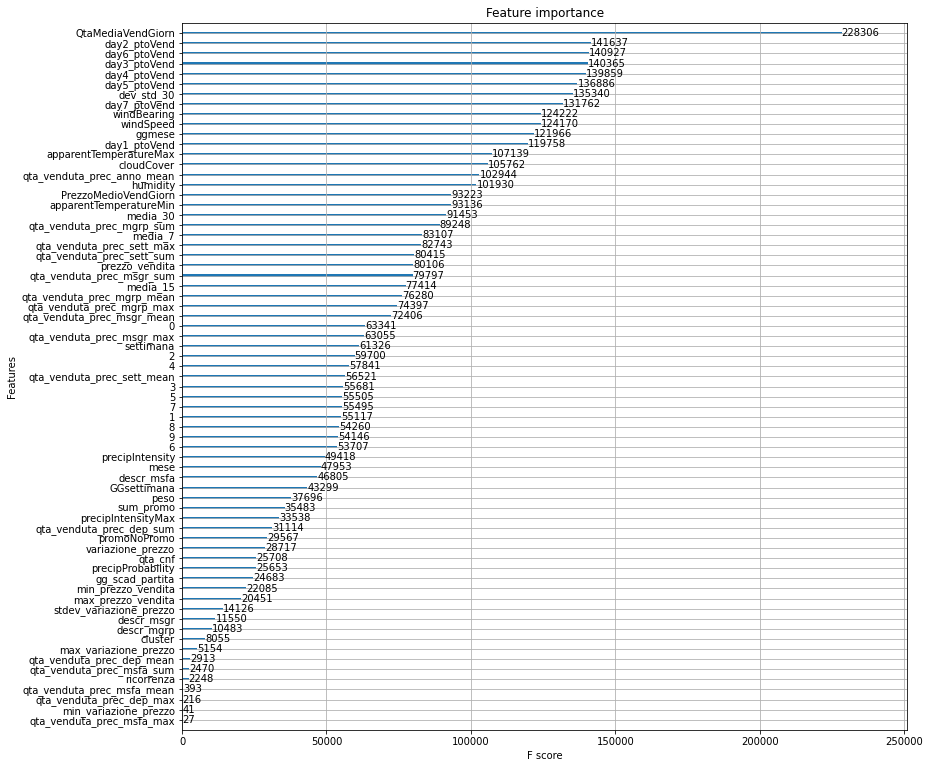

In [95]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [13, 13]
plt.show()

# Data Analysis

In [177]:
df_val['qta_predetta']=np.around(preds)
df_val['agent_sales']=df_val['qta_venduta']-df_val['inevaso']+df_val['QuantitaResa']+df_val['QuantitaSostituita']
df_val['valore_predetto']=df_val['qta_predetta']*df_val.prezzo_vendita
df_val['valore_ottimo']=df_val['qta_venduta']*df_val.prezzo_vendita
df_val['valore_agente']=df_val['agent_sales']*df_val.prezzo_vendita

In [178]:
df=df_val[['cod_mart','mese','ggmese','settimana','qta_venduta','qta_predetta','agent_sales']]

In [179]:
df=df.groupby(['cod_mart','mese','ggmese','settimana']).sum().reset_index()

In [180]:
df[(df.cod_mart==sales_mapping_art['831001'])]

cod_mart  mese  ggmese  settimana  qta_venduta  qta_predetta  \
12743       551     1       2          1         84.0          48.0   
12744       551     1       4          2         93.0          69.0   
12745       551     1       5          2       1203.0        1372.0   
12746       551     1       7          2        715.0         638.0   
12747       551     1       8          2       1265.0        1423.0   
12748       551     1       9          2        188.0         192.0   
12749       551     1      11          3        522.0         580.0   
12750       551     1      12          3       1725.0        1382.0   
12751       551     1      13          3       1156.0        1136.0   
12752       551     1      14          3        686.0         681.0   
12753       551     1      15          3       1496.0        1381.0   
12754       551     1      16          3         91.0          71.0   
12755       551     1      18          4        540.0         530.0   
12756       551     1      19          4       1387.0        1347.0   
12757       551     1      20          4        962.0        1086.0   
12758       551     1      21          4        625.0         727.0   
12759       551     1      22          4       1243.0        1390.0   
12760       551     1      23          4        199.0         142.0   
12761       551     1      25          5        410.0         586.0   
12762       551     1      26          5       1639.0        1356.0   
12763       551     1      27          5       1095.0        1121.0   
12764       551     1      28          5        831.0         747.0   
12765       551     1      29          5       1359.0        1385.0   
12766       551     1      30          5        104.0         111.0   
12767       551     2       1          6        587.0         564.0   
12768       551     2       2          6       1764.0        1358.0   
12769       551     2       3          6        960.0        1138.0   
12770       551     2       4          6        485.0         651.0   
12771       551     2       5          6       1291.0        1445.0   
12772       551     2       6          6        233.0         186.0   
12773       551     2       8          7        404.0         483.0   
12774       551     2       9          7       1603.0        1359.0   
12775       551     2      10          7        883.0        1119.0   
12776       551     2      11          7        555.0         590.0   
12777       551     2      12          7       1455.0        1421.0   
12778       551     2      13          7        140.0         157.0   
12779       551     2      15          8        425.0         472.0   
12780       551     2      16          8       1137.0        1370.0   
12781       551     2      17          8        927.0        1090.0   
12782       551     2      18          8        645.0         643.0   
12783       551     2      19          8       1536.0        1137.0   
12784       551     2      20          8        151.0         107.0   
12785       551     2      22          9        266.0         460.0   
12786       551     2      23          9       1133.0        1382.0   
12787       551     2      24          9        907.0        1081.0   
12788       551     2      25          9        503.0         580.0   
12789       551     2      26          9       1585.0        1389.0   
12790       551     2      27          9         98.0          48.0   
12791       551     3       1         10        303.0         385.0   
12792       551     3       2         10       1266.0        1078.0   
12793       551     3       3         10        933.0         843.0   
12794       551     3       4         10        469.0         473.0   
12795       551     3       5         10       1207.0        1110.0   
12796       551     3       6         10        170.0          35.0   
12797       551     3       8         11        530.0         396.0   
12798       551     3       9  

In [181]:
def plotta_art(cod_mart):
    plt.plot(df[(df.cod_mart==cod_mart)].reset_index().qta_venduta, 'b') # plotting t, b separately 
    plt.plot( df[(df.cod_mart==cod_mart)].reset_index().qta_predetta, 'g') # plotting t, c separately 
    plt.plot( df[(df.cod_mart==cod_mart)].reset_index().agent_sales, 'r') # plotting t, c separately 
    plt.rcParams['figure.figsize'] = [100, 10]
    plt.show()

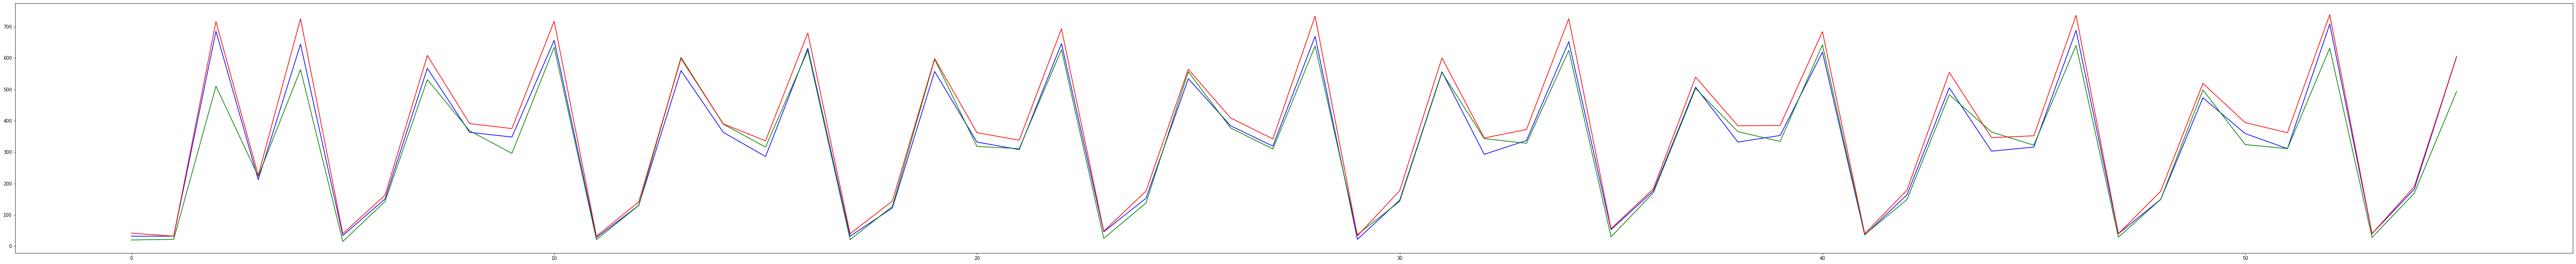

In [189]:
plotta_art(sales_mapping_art['ORT004'])

In [183]:
df[(df.cod_mart==125) & (df.mese<9) & ((df.mese<=2) | (df.mese>=6))]

Empty DataFrame
Columns: [cod_mart, mese, ggmese, settimana, qta_venduta, qta_predetta, agent_sales]
Index: []

# Data Analysis 2

In [184]:
import warnings
from sklearn.metrics import *
codici=df_val.cod_mart.unique()
def evaluate(param,dataFrame,dizionario= sales_mapping_art.items(),tweedie=True):
    evaluation=pd.DataFrame(columns=['expV_score','vendite_medie','maxerr','mae','mse','msle','median_absolut','r2s','mpd','mgd','mtd'])
    if(tweedie):
        dataFrame=dataFrame[(dataFrame.agent_sales>0) &(dataFrame.qta_predetta>0)]
        

    inv_map = {v: k for k, v in dizionario}
    elementi= dataFrame[param].unique()
    for elemento in elementi:
        y_true=dataFrame[dataFrame[param]==elemento].agent_sales
        y_pred=dataFrame[dataFrame[param]==elemento].qta_predetta
        
        vendite_medie=y_true.mean()
        
        evs=explained_variance_score(y_true,y_pred)
    #Explained variance regression score function
        maxerr=max_error(y_true, y_pred)
    #max_error metric calculates the maximum residual error.
        mae=mean_absolute_error(y_true, y_pred)
    #Mean absolute error regression loss.
        mse=mean_squared_error(y_true, y_pred)
    #Mean squared error regression loss.
        msle=mean_squared_log_error(y_true, y_pred)
    #Mean squared logarithmic error regression loss.
        medae=median_absolute_error(y_true, y_pred)
    #Median absolute error regression loss.
       # mape=mean_absolute_percentage_error(y_true,y_pred)
    #Mean absolute percentage error regression loss.
        r2s=r2_score(y_true, y_pred,)
    #R^2 (coefficient of determination) regression score function.
        if tweedie:
            mpd=mean_poisson_deviance(y_true, y_pred)
        #Mean Poisson deviance regression loss.
            mgd=mean_gamma_deviance(y_true, y_pred)
        #Mean Gamma deviance regression loss.
            mtd=mean_tweedie_deviance(y_true, y_pred,power=1.7)
        #Mean Tweedie deviance regression loss.
        else:
            mpd=0
            mgd=0
            mtd=0
        evaluation.loc[inv_map[elemento]]=[evs,vendite_medie,maxerr,mae,mse,msle,medae,r2s,mpd,mgd,mtd]
        warnings.filterwarnings('ignore')
    return evaluation.reset_index().sort_values('vendite_medie',ascending=False)

In [185]:
a=evaluate('cod_mart',df_val[(df_val.cod_mdep==0)],sales_mapping_art.items(),tweedie=True)

In [140]:
a[:500]

index    expV_score  vendite_medie     maxerr          mae  \
267  811825 -1.093644e-01    8003.976190   7403.000  1984.166667   
299  841002  7.214117e-01     909.107143    806.000   160.803571   
312  873201  6.449323e-01     834.821429    774.000   200.017857   
276  831001  8.985069e-01     825.732143    494.000   119.410714   
300  841003  7.388044e-01     767.696429    460.000   125.017857   
161  138611  6.423346e-01     608.428571   1225.000   221.244898   
166  138711  8.121624e-01     576.727273    705.000   133.054545   
313  873202  7.503640e-01     531.698113    389.000    85.981132   
14   010900  6.128452e-01     526.660714    778.000   157.910714   
162  138616  6.089215e-01     509.057692   1237.000   198.826923   
589  ORS021  2.351947e-01     481.454545  12105.000   398.878788   
304  847307  2.230031e-01     477.370370    930.000   130.240741   
168  138719  6.553273e-01     462.962963    717.000   149.185185   
672  POR006  8.655291e-02     459.000000   1267.000   326.000000   
167  138716  7.308467e-01     436.089286    670.000   106.946429   
807  TLP007  7.956126e-01     409.109091    284.000    49.800000   
99   036040  6.841715e-01     404.320755    907.000   131.528302   
410  DUL533  1.174874e-01     384.727273   8339.000   276.545455   
603  ORT004  9.690812e-01     364.482143    142.000    34.017857   
607  ORT011  9.402105e-01     351.387755    111.000    31.734694   
93   036004  4.853656e-01     338.877551    992.000   153.306122   
670  POL023  7.937087e-01     328.964286    147.000    45.714286   
292  833206  2.107473e-01     323.910714    440.000   133.053571   
285  831011  7.657602e-01     322.944444    156.000    53.666667   
302  841020  6.231789e-01     314.196429    231.000    63.767857   
293  834015  8.148058e-01     299.836364    164.000    46.527273   
284  831009  1.805789e-01     291.555556    669.000   128.814815   
92   035864  7.417115e-01     274.927273    509.000    86.490909   
81   035704  7.588256e-01     272.535714    240.000    58.321429   
674  POR009  7.669074e-01     252.860000    133.000    40.500000   
277  831002  8.260357e-01     250.122807    202.000    48.929825   
163  138624  6.802172e-01     221.648148    445.000    86.296296   
286  831014  5.792700e-01     220.888889    162.000    48.244444   
255  752142  5.393774e-01     219.563636    279.000    53.254545   
301  841009  8.012304e-01     215.732143    210.000    38.625000   
808  TLP008  4.419045e-01     214.678571    199.000    52.125000   
608  ORT012  8.183399e-01     212.533333    119.000    33.866667   
622  ORT035  9.531194e-01     211.589286    111.000    30.035714   
278  831003  7.256618e-01     211.181818    132.000    42.854545   
242  700115  7.788978e-01     199.592593    138.000    36.759259   
85   035724  6.432250e-01     194.839286    274.000    57.071429   
244  700210  7.673919e-01     194.113208    391.000    52.000000   
165  138708  4.682490e-01     191.037037    425.000    60.629630   
172  138788  6.712213e-01     189.250000    279.000    64.916667   
298  841001  7.324274e-01     188.321429    146.000    39.607143   
178  165506  7.789039e-01     181.321429    128.000    28.714286   
175  156000  6.694381e-01     177.070175    339.000    53.192982   
601  ORT002  9.209965e-01     174.357143     81.000    24.553571   
406  DUL417  3.069610e-01     172.862745   1678.000    73.333333   
169  138722  7.401249e-01     172.094340    278.000    57.301887   
280  831005  5.969730e-01     171.446429    522.000    45.821429   
94   036007  4.437097e-01     170.020000    646.000    76.820000   
73   033839  7.767437e-01     165.450980    183.000    35.313725   
281  831006  6.864861e-01     158.535714    123.000    34.821429   
89   035767  5.895685e-01     158.145455    268.000    49.945455   
303  841021  3.028997e-01     152.036364    107.000    32.800000   
415  DUL639  8.404931e-01     149.636364    399.000    40.727273   
86   035764  5.412971e-01     149.267857    291.000    41.9642

In [188]:
a[:500]

index   expV_score  vendite_medie     maxerr          mae           mse  \
269  811825    -0.169568    8003.976190   8460.000  2196.357143  7.572259e+06   
303  841002     0.728521     909.107143    767.000   165.696429  4.912773e+04   
316  873201     0.600791     834.821429    914.000   208.464286  9.115593e+04   
278  831001     0.908587     825.732143    422.000   117.964286  2.457046e+04   
304  841003     0.749155     767.696429    485.000   137.160714  3.199895e+04   
161  138611     0.674632     596.380000   1247.000   212.100000  1.279850e+05   
166  138711     0.812400     587.370370    754.000   130.018519  3.785254e+04   
317  873202     0.796274     531.698113    356.000    83.905660  1.212123e+04   
162  138616     0.623537     528.180000   1269.000   202.100000  1.172129e+05   
14   010900     0.667474     526.660714    659.000   154.142857  4.666011e+04   
605  ORS021     0.206448     481.454545  12331.000   404.575758  4.609613e+06   
168  138719     0.642273     480.615385    724.000   148.538462  5.045250e+04   
308  847307     0.338234     477.370370    841.000   118.833333  4.158724e+04   
167  138716     0.736064     436.089286    676.000   107.857143  2.721479e+04   
417  DUL533     0.168246     426.871795   8012.000   329.794872  1.736907e+06   
828  TLP007     0.753402     409.109091    301.000    58.909091  6.912727e+03   
99   036040     0.697994     396.944444    873.000   135.370370  5.284485e+04   
688  POR006     0.132464     370.800000   1276.000   268.600000  3.258614e+05   
619  ORT004     0.969998     364.482143    206.000    41.303571  3.328196e+03   
623  ORT011     0.937181     351.387755    118.000    36.510204  2.073449e+03   
93   036004     0.497014     345.875000    960.000   155.395833  6.538135e+04   
686  POL023     0.794529     328.964286    144.000    45.982143  3.138125e+03   
295  833206     0.173459     323.910714    443.000   135.678571  3.077396e+04   
287  831011     0.744415     322.944444    195.000    57.518519  5.070630e+03   
306  841020     0.550697     319.727273    260.000    70.818182  9.217582e+03   
297  834015     0.822489     299.836364    163.000    45.945455  3.365764e+03   
286  831009     0.209557     291.555556    638.000   132.611111  3.207920e+04   
92   035864     0.720043     279.722222    529.000    90.296296  2.124170e+04   
81   035704     0.763074     272.535714    245.000    56.196429  7.051839e+03   
690  POR009     0.720164     257.959184    132.000    39.959184  2.739102e+03   
279  831002     0.806598     254.553571    179.000    51.321429  5.005357e+03   
163  138624     0.658373     225.641509    427.000    88.056604  2.055500e+04   
288  831014     0.572630     220.888889    150.000    50.444444  4.215333e+03   
255  752142     0.601086     219.563636    271.000    46.509091  5.002655e+03   
305  841009     0.795632     215.732143    211.000    40.250000  2.779821e+03   
829  TLP008     0.449042     214.678571    195.000    50.767857  4.942768e+03   
624  ORT012     0.820159     212.533333    114.000    35.555556  1.903911e+03   
638  ORT035     0.968695     211.589286     74.000    27.928571  1.178643e+03   
280  831003     0.741789     211.181818    130.000    41.454545  2.724036e+03   
242  700115     0.762403     199.592593    146.000    37.481481  2.565148e+03   
85   035724     0.641519     194.839286    276.000    56.732143  7.269054e+03   
244  700210     0.787923     194.113208    358.000    50.452830  7.290830e+03   
165  138708     0.482802     191.037037    429.000    59.500000  1.030591e+04   
172  138788     0.664273     189.250000    317.000    65.625000  9.935583e+03   
302  841001     0.743151     188.321429    120.000    40.982143  2.473125e+03   
178  165506     0.773396     181.321429    122.000    29.339286  1.611482e+03   
175  156000     0.588059     177.070175    378.000    58.491228  9.960421e+03   
617  ORT002     0.926175     174.357143     88.000    30.982143  1.477589e+03   
169  138722     0.733254     172.0943